## Physics Performance Notebook 
notebook used to check the physics performances for different pileup mitigation algorithms.

Outputs the AUC, jet mass bias and resolution, jet pt bias and resolution, and MET pt resolution

Load all needed environments

In [1]:
import argparse
import torch
from torch_geometric.data import DataLoader
import models_ggnn_oldpipe as models
import utils
import matplotlib
from copy import deepcopy
import os
import copy

#matplotlib.use("pdf")
import numpy as np
import random
import pickle
import joblib
from timeit import default_timer as timer
from tqdm import tqdm

import matplotlib as mpl
import imageio

#mpl.use("pdf")
import matplotlib.pyplot as plt
import mplhep as hep

hep.set_style(hep.style.CMS)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

from pyjet import cluster, DTYPE_PTEPM
from collections import OrderedDict
import scipy.stats

True


/depot/cms/private/users/feng356/SSLPUPPI/latest_ggnn_code/utils.py:9: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style(hep.style.ROOT)


define the deltaPhi and deltaR functions

In [2]:
def deltaPhiNew(dphis):
    dphis = np.where(dphis > np.pi, dphis - 2*np.pi, dphis)
    dphis = np.where(dphis <-np.pi, dphis + 2*np.pi, dphis)
    return dphis

def deltaRNew(detas, dphis):
    """
    calculate the deltaR based on the input deta and phi
    """
    dphis = deltaPhiNew(dphis)
    dR = np.sqrt(detas**2 + dphis**2)
    return dR

Do some preprocessings of data, needed for the model

In [3]:
def generate_mask(dataset):
    # how many LV and PU to sample
    # dataset = deepcopy(dataset_org)
    for graph in dataset:
        LV_index = graph.LV_index
        PU_index = graph.PU_index
        original_feature = graph.x[:, 0:graph.num_feature_actual]

        num_select_LV = 10
        num_select_PU = 160

        if LV_index.shape[0] < num_select_LV or PU_index.shape[0] < num_select_PU:
            num_select_LV = min(LV_index.shape[0], num_select_LV)
            num_select_PU = min(PU_index.shape[0], num_select_PU)

        # generate the index for LV and PU samples for training mask
        gen_index_LV = random.sample(range(LV_index.shape[0]), num_select_LV)
        selected_LV_train = LV_index[gen_index_LV]

        gen_index_PU = random.sample(range(PU_index.shape[0]), num_select_PU)
        selected_PU_train = PU_index[gen_index_PU]

        training_mask = np.concatenate((selected_LV_train, selected_PU_train), axis=None)
        #print(training_mask)

        # construct mask vector for training and testing
        mask_training = torch.zeros(graph.num_nodes, 1)
        mask_training[[training_mask.tolist()]] = 1

        x_concat = torch.cat((original_feature, mask_training), 1)
        graph.x = x_concat

        # mask the puppiWeight as default Neutral(here puppiweight is actually fromLV in ggnn dataset)
        puppiWeight_default_training = torch.zeros(graph.num_nodes)

        # in order for one hot encoding to work, so we set neutral to be 1. This will not affect the final x
        puppiWeight_default_training[[graph.Neutral_index]] = 1
        puppiWeight_default_training[[training_mask.tolist()]] = 2

        # one hot encoding for puppiWeight
        puppiWeight_default_training = puppiWeight_default_training.type(torch.long)
        puppiWeight_default_one_hot_training = torch.nn.functional.one_hot(puppiWeight_default_training)
        puppiWeight_default_one_hot_training = puppiWeight_default_one_hot_training.type(torch.float32)

        # -4 is for one hot encoding of fromLV and one mask; -1 is for final puppiweight
        default_data_training = torch.cat(
            (original_feature[:, 0:(graph.num_features - 4 - 1)], puppiWeight_default_one_hot_training,
             original_feature[:, -1].view(-1, 1)), 1)

        concat_default = torch.cat((graph.x, default_data_training), 1)
        graph.x = concat_default

In [4]:
def generate_neu_mask(dataset):
    # all neutrals with pt cuts are masked for evaluation
    for graph in dataset:
        nparticles = graph.num_nodes
        graph.num_feature_actual = graph.num_features
        Neutral_index = graph.Neutral_index
        Neutral_feature = graph.x[Neutral_index]
        Neutral_index = Neutral_index[torch.where(Neutral_feature[:, 2] > 0.5)[0]]

        mask_neu = torch.zeros(nparticles, 1)
        mask_neu[Neutral_index, 0] = 1
        graph.mask_neu = mask_neu

    return dataset

Load and pre-process the graphs

In [5]:
class Args(object):
    def __init__(self, model_type = 'Gated_no_at', do_boost=False, extralayers=False):
        self.model_type = model_type
        self.num_layers = 2
        self.batch_size = 1
        self.hidden_dim = 20
        self.dropout = 0
        self.opt = 'adam'
        self.weight_decay = 0
        self.lr = 0.01
        self.do_boost = do_boost
        self.extralayers = extralayers

In [6]:
args = Args()

Load the model

In [7]:
class PerformanceMetrics(object):
    def __init__(self):
        pt = 0.
        pt_diff = 0.
        mass_diff = 0.
        dR_diff = 0.

In [8]:
def clusterJets(pt, eta, phi, ptcut=0., deltaR=0.7):
    """
    cluster the jets based on the array of pt, eta, phi,
    of all particles (masses are assumed to be zero),
    with pyjet clustering algo
    """
    # cleaning zero pt-ed objects
    pt_wptcut   = pt[pt > ptcut]
    eta_wptcut  = eta[pt > ptcut]
    phi_wptcut  = phi[pt > ptcut]
    mass_wptcut = np.zeros(pt_wptcut.shape[0])
    
    event = np.column_stack((pt_wptcut, eta_wptcut, phi_wptcut, mass_wptcut))
    event.dtype = DTYPE_PTEPM
    sequence = cluster(event, R=deltaR, p=-1)
    jets = sequence.inclusive_jets(ptmin=30)
    
    return jets

def deltaPhi(phi1, phi2):
    dphi = phi1 - phi2
    while dphi > np.pi:
        dphi -= 2 * np.pi
    while dphi < -np.pi:
        dphi += 2 * np.pi
    return dphi

def deltaR(eta1, phi1, eta2, phi2):
    """
    calculate the deltaR between two jets/particles
    """
    deta = eta1 - eta2
    dphi = phi1 - phi2
    while dphi > np.pi:
        dphi -= 2 * np.pi
    while dphi < -np.pi:
        dphi += 2 * np.pi
    return np.hypot(deta, dphi)

def deltaRJet(jet1, jet2):
    """
    calculate the deltaR of the two PseudoJet
    """
    return deltaR(jet1.eta, jet1.phi, jet2.eta, jet2.phi)

def matchJets(jets_truth, jets_reco, dRcut=0.1):
    """
    match the jets in jets_reco to jets_truth,
    based on the deltaR
    """
    matched_indices = []
    
    jets_truth_indices = list(range(len(jets_truth)))
    jets_reco_indices  = list(range(len(jets_reco)))
    
    for ijet_reco in jets_reco_indices:
        for ijet_truth in jets_truth_indices:
            #print("deltR between {} and {} is {}".format(ijet_truth, ijet_reco, deltaRJet(jets_truth[ijet_truth], jets_reco[ijet_reco])))
            if deltaRJet(jets_truth[ijet_truth], jets_reco[ijet_reco]) < dRcut:
                matched_indices.append((ijet_truth, ijet_reco))
                jets_truth_indices.remove(ijet_truth)
                break
    
    return matched_indices

def compareJets(jets_truth, jets_reco, dRcut=0.1):
    """
    match jets between truth and reco using matchJets,
    and then compared the matched deltaR, pt, and mass
    """
    performances = []
    
    matched_indices = matchJets(jets_truth, jets_reco, dRcut=dRcut)
    for ijet_truth, ijet_reco in matched_indices:
        perf = PerformanceMetrics()
        perf.pt_truth = jets_truth[ijet_truth].pt
        perf.mass_diff =  (jets_reco[ijet_reco].mass - jets_truth[ijet_truth].mass)/(jets_truth[ijet_truth].mass+1e-6)
        perf.pt_diff   =  (jets_reco[ijet_reco].pt   - jets_truth[ijet_truth].pt)/(jets_truth[ijet_truth].pt+1e-6)
        perf.dR_diff   =  deltaRJet(jets_truth[ijet_truth], jets_reco[ijet_reco])
        performances.append(perf)
    return performances

def calculateMET(pt, phi):
    """
    calculate the MET based on all particles pt and phi
    """
    met_x = np.sum(pt * np.cos(phi), axis=0)
    met_y = np.sum(pt * np.sin(phi), axis=0)
    return np.hypot(met_x, met_y)
        

In [9]:
def postProcessing(data, preds):
    """
    reconstruct jet and MET,
    compare the reco-ed jet and MET with truth ones,
    using the input data and ML weights (pred)
    """
    pt  = np.array(data.x[:,2].cpu().detach())
    eta = np.array(data.x[:,0].cpu().detach())
    phi = np.array(data.x[:,1].cpu().detach())
    puppi = np.array(data.x[:,data.num_feature_actual[0].item()-1].cpu().detach())
    truth = np.array(data.y.cpu().detach())
    #pred = np.array(pred[:,0].cpu().detach())
    #pred2 = np.array(pred2[:, 0].cpu().detach())
    # set all particle masses to zero
    mass = np.zeros(pt.shape[0])
    
    # remove pt < 0.5 particles
    pt[pt<0.5]=0
        
    # apply CHS to puppi weights
    charge_index = data.Charge_index[0]
    puppi[charge_index] = truth[charge_index]
    # apply CHS to predicted weights
    #pred[charge_index] = truth[charge_index]
    #pred2[charge_index] = truth[charge_index]
    
    # truth information
    pt_truth   = pt * truth
    
    # puppi information
    pt_puppi = pt * puppi
    # apply some weight cuts on puppi
    #cut = 0.41 #GeV
    wcut = 0.17
    cut = 0.99 #GeV
    #cut = 0.99 #GeV
    #wcut = 0.15
    #cut = 1.242 #GeV
    #wcut = 0.115
    pt_puppi_wcut = np.array(pt_puppi, copy=True)
    pt_puppi_wcut[(puppi<wcut) | (pt_puppi<cut)] = 0.
    
    # prediction information
    #pt_pred = pt * pred
    #pt_pred2 = pt * pred2

    # cluster jets with truth particles
    jets_truth = clusterJets(pt_truth, eta, phi)
    
    jets_puppi = clusterJets(pt_puppi, eta, phi)
    performances_jet_puppi = compareJets(jets_truth, jets_puppi)
    
    jets_puppi_wcut = clusterJets(pt_puppi_wcut, eta, phi)
    performances_jet_puppi_wcut = compareJets(jets_truth, jets_puppi_wcut)
    
    #jets_pred  = clusterJets(pt_pred,  eta, phi)
    #print("pt_pred: ", jets_pred)
    #performances_jet_pred = compareJets(jets_truth, jets_pred)
    
    #jets_pred2 = clusterJets(pt_pred2, eta, phi)
    #print("pt_pred2", jets_pred2)
    #performances_jet_pred2 = compareJets(jets_truth, jets_pred2)
    
    # calculate MET and compare
    met_truth = calculateMET(pt_truth, phi)
    met_puppi = calculateMET(pt_puppi, phi)
    met_puppi_wcut = calculateMET(pt_puppi_wcut, phi)
    #met_pred  = calculateMET(pt_pred,  phi)
    #met_pred2 = calculateMET(pt_pred2, phi)
    #print("***** one event ********")
    #print("met truth", met_truth)
    #print("met puppi", met_puppi)
    #print("met puppi wcut", met_puppi_wcut)
    #print("met pred", met_pred)
    #print("met pred2", met_pred2)
    
    # evaluate the performances for the predictions
    performances_jet_pred = []
    mets_pred = []
    
    for pred in preds:
        #print("preds: ", pred)
        pred = np.array(pred[0][:,0].cpu().detach())
        
        # apply CHS to predictions
        charge_index = data.Charge_index[0]
        pred[charge_index] = truth[charge_index]
        pt_pred = pt * pred
        jets_pred  = clusterJets(pt_pred,  eta, phi)
        performance_jet_pred = compareJets(jets_truth, jets_pred)
        
        # MET
        met_pred  = calculateMET(pt_pred,  phi)
        
        performances_jet_pred.append( performance_jet_pred )
        mets_pred.append( met_pred )

    return met_truth, performances_jet_puppi, met_puppi, performances_jet_puppi_wcut, met_puppi_wcut, performances_jet_pred, mets_pred 
    

Provide a list of pickle files, run the model, and evalualte the performance

In [10]:
def test(filelists, models={}):
    
    for model in models.values():
        model.to('cuda:0')
        model.eval()
    
    performances_jet_puppi = []
    performances_jet_puppi_wcut = []
    
    mets_truth = []
    mets_puppi = []
    mets_puppi_wcut = []
    
    performances_jet_pred = OrderedDict()
    mets_pred = OrderedDict()
    for modelname in models.keys():
        performances_jet_pred[modelname] = []
        mets_pred[modelname] = []
    
    ievt = 0
    for ifile in filelists:
        print("ifile: ", ifile)
        fp = open(ifile, "rb")
        dataset = joblib.load(fp)
        generate_neu_mask(dataset)
        generate_mask(dataset)
        data = DataLoader(dataset, batch_size=1)
        loader = data
        
        for data in loader:
            ievt += 1
            #if ievt > 10:
            #    break
            
            if ievt%10 == 0:
                print("processed {} events".format(ievt))
            with torch.no_grad():
                data = data.to(device)
                # max(dim=1) returns values, indices tuple; only need indices
                
                # loop over model in models and run the inference
                preds = []

                for model in models.values():
                    model.to('cuda:0')
                    model.eval()
                    
                    pred = model.forward(data)
                    #print("pred here: ", pred)
                    preds.append(pred)
            
                met_truth, perfs_jet_puppi, met_puppi, perfs_jet_puppi_wcut, met_puppi_wcut, perfs_jet_pred, mets_fromF_pred = postProcessing(data, preds)
                #perfs_jet_puppi, perfs_jet_puppi_wcut, perfs_jet_pred, perfs_jet_pred2, met_truth, met_puppi, met_puppi_wcut, met_pred, met_pred2 = postProcessing(data, preds)
            
                performances_jet_puppi += perfs_jet_puppi
                performances_jet_puppi_wcut += perfs_jet_puppi_wcut
                #performances_jet_pred += perfs_jet_pred
                #performances_jet_pred2 += perfs_jet_pred2
                
                mets_truth.append(met_truth)
                mets_puppi.append(met_puppi)
                mets_puppi_wcut.append(met_puppi_wcut)
                
                imodel = 0
                for modelname in models.keys():
                    #print("modelname ", perfs_jet_pred[imodel])
                    #print("performances_jet_pred modelname", performances_jet_pred[modelname] )
                    performances_jet_pred[modelname] += perfs_jet_pred[imodel]
                    mets_pred[modelname].append(mets_fromF_pred[imodel])
                    imodel += 1
                
        fp.close()


    return mets_truth, performances_jet_puppi, mets_puppi, performances_jet_puppi_wcut, mets_puppi_wcut, performances_jet_pred, mets_pred



Prepare the list of input files for testing

In [11]:
filelists = [
    "/depot/cms/private/users/feng356/SSLPUPPI_data/pickle/Znunu_PU80_part2.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_70.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_71.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_72.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_73.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_74.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_75.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_76.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_77.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_78.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_79.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_82.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_83.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_84.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_85.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_86.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_87.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_88.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_89.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_90.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_91.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_92.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_93.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_94.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_95.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_96.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_97.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_98.pickle",
    #"/data/Graph_80/ZnunuPlusJet_13TeV_80PU_withUnderlyingEvent_99.pickle",
]

Prepare the list of model files for testing

In [12]:
ifile = "/depot/cms/private/users/feng356/SSLPUPPI_data/pickle/Znunu_PU80_part2.pickle"
fp = open(ifile, "rb")
dataset = joblib.load(fp)
generate_neu_mask(dataset)
generate_mask(dataset)

In [13]:
dataset[0].num_feature_actual

7

Load the models trained at PU=80

In [15]:
#model_gated_boost = models.GNNStack(dataset[0].num_feature_actual, args.hidden_dim, 1, Args(do_boost=False, extralayers=True),True,False)
model_gated_boost = models.GNNStack(7, args.hidden_dim, 1, Args(do_boost=True, extralayers=True),True,False)
#model_load.load_state_dict(torch.load('best_valid_model_semi.pt'))
model_gated_boost.load_state_dict(torch.load('/depot/cms/private/users/feng356/SSLPUPPI/saved_models/sig2_results/Gated_PU80_deltar04_semi/best_valid_model.pt'))



<All keys matched successfully>

In [16]:
model_gated_boost_sp = models.GNNStack(7, args.hidden_dim, 1, Args(do_boost=True, extralayers=False),True,False)
model_gated_boost_sp.load_state_dict(torch.load('/depot/cms/private/users/feng356/SSLPUPPI/saved_models/sig2_results/Gated_PU80_deltar04_sup/best_valid_model.pt'))


<All keys matched successfully>

In [17]:
modelcolls = OrderedDict()
modelcolls['gated_boost'] = model_gated_boost
modelcolls['gated_boost_sp'] = model_gated_boost_sp

Run the inference on the list of inputs

In [18]:
mets_truth, performances_jet_puppi, mets_puppi, performances_jet_puppi_wcut, mets_puppi_wcut, performances_jet_pred, mets_pred = test(filelists, modelcolls)


ifile:  /depot/cms/private/users/feng356/SSLPUPPI_data/pickle/Znunu_PU80_part2.pickle
processed 10 events
processed 20 events
processed 30 events
processed 40 events
processed 50 events
processed 60 events
processed 70 events
processed 80 events
processed 90 events
processed 100 events
processed 110 events
processed 120 events
processed 130 events
processed 140 events
processed 150 events
processed 160 events
processed 170 events
processed 180 events
processed 190 events
processed 200 events
processed 210 events
processed 220 events
processed 230 events
processed 240 events
processed 250 events
processed 260 events
processed 270 events
processed 280 events
processed 290 events
processed 300 events
processed 310 events
processed 320 events
processed 330 events
processed 340 events
processed 350 events
processed 360 events
processed 370 events
processed 380 events
processed 390 events
processed 400 events
processed 410 events
processed 420 events
processed 430 events
processed 440 events

Check the jet level performances

In [19]:
print([getattr(perf, "pt_diff") for perf in performances_jet_puppi])
print(len([getattr(perf, "pt_diff") for perf in performances_jet_puppi_wcut]))

[0.07689562809929548, 0.46234267395864886, 0.08098637112389206, 0.18866345243728846, 0.22852748226162034, 0.1864825901225937, 0.0915005665433053, 0.21214037201143596, 0.20835393712903227, 0.1096795409934436, 0.3440755317072451, 0.1094950207579108, 0.11026904631719538, 0.31482653867700544, -0.012795879366617772, 0.20314916593395246, 0.32137570061193244, 0.20187376344602306, 0.7056665542307892, 0.11300150278007624, 0.26741553810217056, 0.18611873202946083, 0.15275676705532512, 0.28463143575226146, 0.21867543804969877, 0.35090259929437834, 0.029978228838473356, 0.10516217907505002, -0.03609048907354509, 0.2105296465019826, 0.25249031688732365, 0.18040372234114588, 0.1717193664137669, 0.147073726209969, 0.19294883263688795, 0.3725907055097237, 0.12439098376093732, 0.1294332493601192, 0.21407957957237603, 0.16519652689331146, 0.040542172013210365, 0.01848851644326976, 0.19458967735593707, 0.13463640556788423, 0.17803869702402828, 0.16617365435399814, 0.3734859493853344, 0.46523090000787, 0.

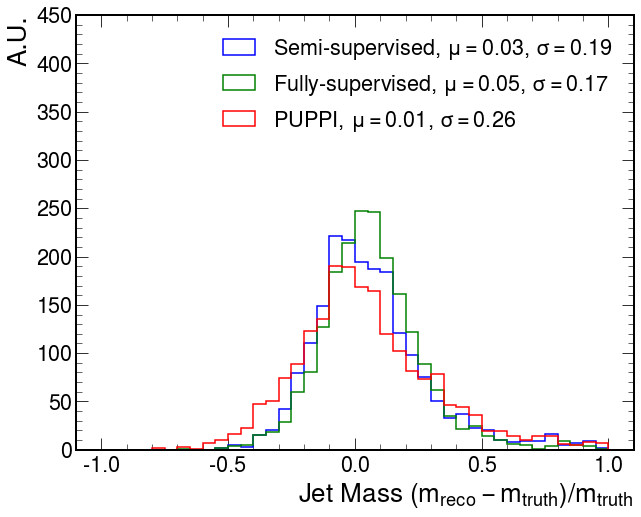

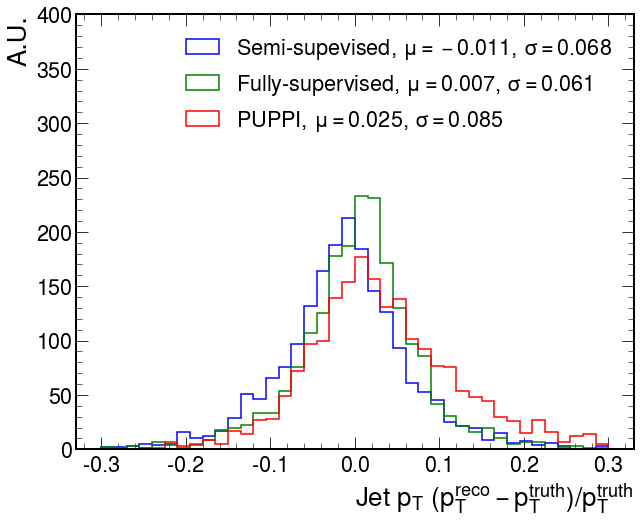

<Figure size 720x720 with 0 Axes>

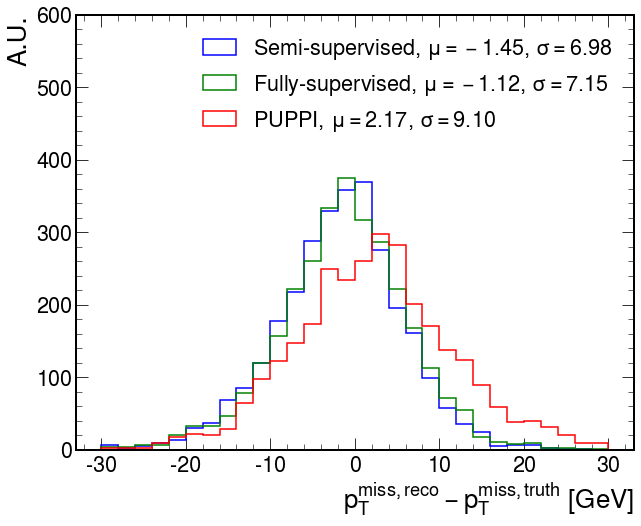

<Figure size 720x720 with 0 Axes>

In [20]:
def getResol(input):
    return (np.quantile(input, 0.84) - np.quantile(input, 0.16))/2

def getStat(input):
    return float(np.median(input)), float(getResol(input))

performances_jet_pred0 = performances_jet_pred['gated_boost']
#performances_jet_pred1 = performances_jet_pred['gated_noboost']
#performances_jet_pred2 = performances_jet_pred['graphsage_boost']
#performances_jet_pred3 = performances_jet_pred['graphsage_noboost']
performances_jet_pred4 = performances_jet_pred['gated_boost_sp']


mets_pred0 = mets_pred['gated_boost']
#mets_pred1 = mets_pred['gated_noboost']
#mets_pred2 = mets_pred['graphsage_boost']
#mets_pred3 = mets_pred['graphsage_noboost']
mets_pred4 = mets_pred['gated_boost_sp']

linewidth=1.5


%matplotlib inline
plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(10,8))
mass_diff = np.array([getattr(perf, "mass_diff") for perf in performances_jet_pred0])
plt.hist(mass_diff, bins=40, range=(-1,1), histtype='step', color='blue', linewidth=linewidth, density=False, label=r'Semi-supervised, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mass_diff))))
mass_diff = np.array([getattr(perf, "mass_diff") for perf in performances_jet_pred4])
plt.hist(mass_diff, bins=40, range=(-1,1), histtype='step', color='green', linewidth=linewidth, density=False, label=r'Fully-supervised, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mass_diff))))
mass_diff = np.array([getattr(perf, "mass_diff") for perf in performances_jet_puppi_wcut])
plt.hist(mass_diff, bins=40, range=(-1,1), histtype='step', color='red', linewidth=linewidth, density=False, label=r'PUPPI, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mass_diff))))
#plt.xlim(-1.0,1.3)
plt.xlabel(r"Jet Mass $(m_{reco} - m_{truth})/m_{truth}$")
plt.ylabel('A.U.')
plt.ylim(0, 450)
plt.legend()
plt.savefig("Jet_mass_diff.pdf")
plt.show()


#%matplotlib inline
fig = plt.figure(figsize=(10,8))

pt_diff = np.array([getattr(perf, "pt_diff") for perf in performances_jet_pred0])
plt.hist(pt_diff, bins=40, range=(-0.3,0.3), histtype='step', color='blue', linewidth=linewidth, density=False, label=r'Semi-supevised, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(pt_diff))))
pt_diff = np.array([getattr(perf, "pt_diff") for perf in performances_jet_pred4])
plt.hist(pt_diff, bins=40, range=(-0.3,0.3), histtype='step', color='green', linewidth=linewidth, density=False, label=r'Fully-supervised, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(pt_diff))))
pt_diff = np.array([getattr(perf, "pt_diff") for perf in performances_jet_puppi_wcut])
plt.hist(pt_diff, bins=40, range=(-0.3,0.3), histtype='step', color='red', linewidth=linewidth, density=False, label=r'PUPPI, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(pt_diff))))
#plt.xlim(0,40)
plt.ylim(0, 400)
plt.xlabel(r"Jet $p_{T}$ $(p^{reco}_{T} - p^{truth}_{T})/p^{truth}_{T}$")
plt.ylabel('A.U.')
plt.legend()
plt.show()
plt.savefig("Jet_pT_diff.pdf")

"""
#%matplotlib inline
fig = plt.figure(figsize=(10,8))
dR_diff = np.array([getattr(perf, "dR_diff") for perf in performances_jet_puppi])
plt.hist(dR_diff, bins=20, range=(0,0.05), histtype='step', color='red', density=False, label=r'PUPPI, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(dR_diff))))
dR_diff = np.array([getattr(perf, "dR_diff") for perf in performances_jet_puppi_wcut])
plt.hist(dR_diff, bins=20, range=(0,0.05), histtype='step', color='magenta', density=False, label=r'PUPPI w Cuts, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(dR_diff))))
dR_diff = np.array([getattr(perf, "dR_diff") for perf in performances_jet_pred0])
plt.hist(dR_diff, bins=20, range=(0,0.05), histtype='step', color='b', density=False, label=r'Gated Boost, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(dR_diff))))
dR_diff = np.array([getattr(perf, "dR_diff") for perf in performances_jet_pred1])
plt.hist(dR_diff, bins=20, range=(0,0.05), histtype='step', color='g', density=False, label=r'Gated noBoost, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(dR_diff))))
dR_diff = np.array([getattr(perf, "dR_diff") for perf in performances_jet_pred2])
plt.hist(dR_diff, bins=20, range=(0,0.05), histtype='step', color='yellow', density=False, label=r'GS Boost, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(dR_diff))))
dR_diff = np.array([getattr(perf, "dR_diff") for perf in performances_jet_pred3])
plt.hist(dR_diff, bins=20, range=(0,0.05), histtype='step', color='orange', density=False, label=r'GS noBoost, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(dR_diff))))
dR_diff = np.array([getattr(perf, "dR_diff") for perf in performances_jet_pred4])
plt.hist(dR_diff, bins=20, range=(0,0.05), histtype='step', color='purple', density=False, label=r'Gated Boost SP, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(dR_diff))))
#plt.xlim(0,40)
plt.ylim(0, 1000)
plt.xlabel(r"Jet Spatial Resolution $\Delta$R")
plt.ylabel('A.U.')
plt.legend()
plt.show()
plt.savefig("Jet_dR_diff.pdf")
"""


# MET resolution
#%matplotlib inline

fig = plt.figure(figsize=(10,8))
mets_diff = (np.array(mets_pred0) - np.array(mets_truth))
plt.hist(mets_diff, bins=30, range=(-30,30), histtype='step', color='blue', linewidth=linewidth, density=False, label=r'Semi-supervised, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mets_diff))))
mets_diff = (np.array(mets_pred4) - np.array(mets_truth))
plt.hist(mets_diff, bins=30, range=(-30,30), histtype='step', color='green', linewidth=linewidth, density=False, label=r'Fully-supervised, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mets_diff))))
mets_diff = (np.array(mets_puppi_wcut) - np.array(mets_truth))
plt.hist(mets_diff, bins=30, range=(-30,30), histtype='step', color='red', linewidth=linewidth, density=False, label=r'PUPPI, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mets_diff))))

plt.xlabel(r"$p^{miss, reco}_{T} - p^{miss, truth}_{T}$ [GeV]")
plt.ylabel('A.U.')
plt.ylim(0,600)
plt.legend()
plt.show()
plt.savefig("MET_diff.pdf")

### Reprocessing the data to do some per-event plots and statistis. 

This can probably be combined with the previous section


In [25]:
ifile = "/depot/cms/private/users/feng356/SSLPUPPI_data/pickle/Znunu_PU80_part2.pickle"
#ifile = "/data/Graph_20/ZnunuPlusJet_iPUPPI_PU20_TEST2_101.pickle"
#ifile = "/data/Graph_140/HbbPlusJet_13TeV_140PU_113.pickle"
fp = open(ifile, "rb")
dataset = joblib.load(fp)
generate_neu_mask(dataset)
generate_mask(dataset)
data = DataLoader(dataset, batch_size=1)

count the statistics. Get the average number of charged/neutral LV/PU particles per event

In [26]:
# count the statistics

iters = iter(data)

eta_truths = []
phi_truths = []
pt_truths = []

counts_chglv = []
counts_chgpu = []
counts_neulv = []
counts_neupu = []

for i in range(100):
    res = iters.next()
    pt  = np.array(res.x[:,2])
    
    truth = np.array(res.y)
    #print(truth.shape)

    charge_index = res.Charge_index[0]
    charge = np.zeros(pt.shape[0])
    charge[charge_index] = 1
    
    chargedLV = pt[(charge==1) & (truth==1)]
    chargedPU = pt[(charge==1) & (truth==0)]
    neutralLV = pt[(charge==0) & (truth==1)]
    neutralPU = pt[(charge==0) & (truth==0)]
    
    counts_chglv.append(np.sum(chargedLV>0.5))
    counts_chgpu.append(np.sum(chargedPU>0.5))
    counts_neulv.append(np.sum(neutralLV>0.5))
    counts_neupu.append(np.sum(neutralPU>0.5))

In [27]:
print(np.mean(counts_chglv), np.std(counts_chglv))
print(np.mean(counts_chgpu), np.std(counts_chgpu))
print(np.mean(counts_neulv), np.std(counts_neulv))
print(np.mean(counts_neupu), np.std(counts_neupu))

71.92 37.90163057178412
1642.87 330.6228562879463
44.36 24.089632624845073
822.31 179.78196210966215


In [29]:
xgbmodel_load = xgb.Booster()
xgbmodel_load.load_model("xgb_model.json")

## Jet image

make the jet image comparisons

In [30]:
iters = iter(data)

eta_truths = np.array([])
phi_truths = np.array([])
charge_truths = np.array([])
pt_truths = np.array([])
pt_truth_scaled = np.array([])


## LV particles
eta_lvs = np.array([])
phi_lvs = np.array([])
charge_lvs = np.array([])
pt_lvs = np.array([])
pt_lv_scaled = np.array([])

pt_lv_puppi = np.array([])
pt_lv_puppi_scaled = np.array([])
pt_lv_pred = np.array([])
pt_lv_pred_scaled = np.array([])
pt_lv_pred_post = np.array([])
pt_lv_pred_post_scaled = np.array([])
pt_lv_predsl = np.array([])
pt_lv_predsl_scaled = np.array([])

## PU particles
eta_pus = np.array([])
phi_pus = np.array([])
charge_pus = np.array([])
pt_pus = np.array([])
pt_pu_scaled = np.array([])

pt_pu_puppi = np.array([])
pt_pu_puppi_scaled = np.array([])

pt_pu_pred = np.array([])
pt_pu_pred_scaled = np.array([])

pt_pu_pred_post = np.array([])
pt_pu_pred_post_scaled = np.array([])

pt_pu_predsl = np.array([])
pt_pu_predsl_scaled = np.array([])

njets = 0
model_gated_boost.to('cuda:0')
model_gated_boost_sp.to('cuda:0')

for i in range(3000):
    if i%100==0:
        print(f"finished {i}")
    res = iters.next()

    res_gpu = res.to(device)

    model_gated_boost.eval()
    pred_gpu = model_gated_boost.forward(res_gpu)
    pred = np.array(pred_gpu[0][:,0].cpu().detach())
    
    a = np.vstack(pred)
    dt = xgb.DMatrix(np.vstack(a))
    pred_post = xgbmodel_load.predict(dt)
    
    model_gated_boost_sp.eval()
    predsl_gpu = model_gated_boost_sp.forward(res_gpu)
    predsl = np.array(predsl_gpu[0][:,0].cpu().detach())

    pt  = np.array(res.x[:,2].cpu().detach())
    eta = np.array(res.x[:,0].cpu().detach())
    phi = np.array(res.x[:,1].cpu().detach())

    puppi = np.array(res.x[:,res.num_feature_actual[0].item()-1].cpu().detach())
    #print(puppi.shape)
    truth = np.array(res.y.cpu().detach())
    
    charge_index = res.Charge_index[0]
    charge = np.zeros(pt.shape[0])
    charge[charge_index] = 1

    jets_pred  = clusterJets(pt[truth==1],  eta[truth==1], phi[truth==1])
    if len(jets_pred) == 0:
        continue
    njets += 1
    jet1st_pt  = jets_pred[0].pt
    jet1st_eta = jets_pred[0].eta
    jet1st_phi = jets_pred[0].phi, 

    #selection = (abs(eta-jet1st_eta) < 0.3 ) & (abs(deltaPhi(phi-jet1st_phi))<0.3)
    selection = np.ones(eta.shape[0], dtype=bool)
    eta_truths = np.hstack([eta_truths, (eta-jet1st_eta)[selection & (truth==1)]])
    phi_truths = np.hstack([phi_truths, deltaPhiNew(phi-jet1st_phi)[selection & (truth==1)]])
    charge_truths = np.hstack([charge_truths, charge[selection & (truth==1)]])
    pt_truths  = np.hstack([pt_truths,  pt[selection & (truth==1)]])
    pt_truth_scaled = np.hstack([pt_truth_scaled, pt[selection & (truth==1)]/jet1st_pt])
    
    # LV after puppi, ssl-gnn, sl-gnn
    selection_lv = (selection & (truth==1) & (charge==0))
    eta_lvs = np.hstack([eta_lvs, (eta-jet1st_eta)[selection_lv]])
    phi_lvs = np.hstack([phi_lvs, deltaPhiNew(phi-jet1st_phi)[selection_lv]])
    pt_lvs = np.hstack([pt_lvs, pt[selection_lv]])
    pt_lv_scaled = np.hstack([pt_lv_scaled, (pt/jet1st_pt)[selection_lv]])
    
    pt_lv_puppi = np.hstack([pt_lv_puppi, (pt*puppi)[selection_lv]])
    pt_lv_puppi_scaled = np.hstack([pt_lv_puppi_scaled, (pt*puppi)[selection_lv]/jet1st_pt])
    
    pt_lv_pred = np.hstack([pt_lv_pred, (pt*pred)[selection_lv]])
    pt_lv_pred_scaled = np.hstack([pt_lv_pred_scaled, (pt*pred)[selection_lv]/jet1st_pt])
    
    pt_lv_pred_post = np.hstack([pt_lv_pred_post, (pt*pred_post)[selection_lv]])
    pt_lv_pred_post_scaled = np.hstack([pt_lv_pred_post_scaled, (pt*pred_post)[selection_lv]/jet1st_pt])
    
    pt_lv_predsl = np.hstack([pt_lv_predsl, (pt*predsl)[selection_lv]])
    pt_lv_predsl_scaled = np.hstack([pt_lv_predsl_scaled, (pt*predsl)[selection_lv]/jet1st_pt])
    
    # PU after PUPPI, SSL-GNN, SL-GNN
    selection_pu = (selection & (truth==0) & (charge==0))
    eta_pus = np.hstack([eta_pus, (eta-jet1st_eta)[ selection_pu ]])
    phi_pus = np.hstack([phi_pus, deltaPhiNew(phi-jet1st_phi)[ selection_pu ]])
    pt_pus  = np.hstack([pt_pus,  pt[ selection_pu ]])
    pt_pu_scaled = np.hstack([pt_pu_scaled,  (pt/jet1st_pt)[selection_pu]])
    charge_pus = np.hstack([charge_pus,     charge[selection_pu]])
    
    pt_pu_puppi = np.hstack([pt_pu_puppi,(pt*puppi)[selection_pu]])
    pt_pu_puppi_scaled = np.hstack([pt_pu_puppi_scaled, (pt*puppi)[selection_pu]/jet1st_pt])
    
    pt_pu_pred = np.hstack([pt_pu_pred,  (pt*pred)[ selection_pu ]])
    pt_pu_pred_scaled = np.hstack([pt_pu_pred_scaled,   (pt*pred)[selection_pu]/jet1st_pt])
    
    pt_pu_pred_post = np.hstack([pt_pu_pred,  (pt*pred_post)[ selection_pu ]])
    pt_pu_pred_post_scaled = np.hstack([pt_pu_pred_post_scaled,   (pt*pred_post)[selection_pu]/jet1st_pt])
    
    pt_pu_predsl = np.hstack([pt_pu_predsl,  (pt*predsl)[selection_pu]])
    pt_pu_predsl_scaled = np.hstack([pt_pu_predsl_scaled,   (pt*predsl)[selection_pu]/jet1st_pt])
    
pt_lv_puppi_scaled[pt_lv_puppi<1.0]=0
pt_lv_puppi[pt_lv_puppi<1.0]=0
    
pt_pu_puppi_scaled[pt_pu_puppi<1.0]=0
pt_pu_puppi[pt_pu_puppi<1.0]=0
    
    

finished 0
finished 100
finished 200
finished 300
finished 400
finished 500
finished 600
finished 700
finished 800
finished 900
finished 1000
finished 1100
finished 1200
finished 1300
finished 1400
finished 1500
finished 1600
finished 1700
finished 1800
finished 1900
finished 2000
finished 2100
finished 2200
finished 2300
finished 2400
finished 2500
finished 2600
finished 2700
finished 2800
finished 2900


In [31]:
njets

1871

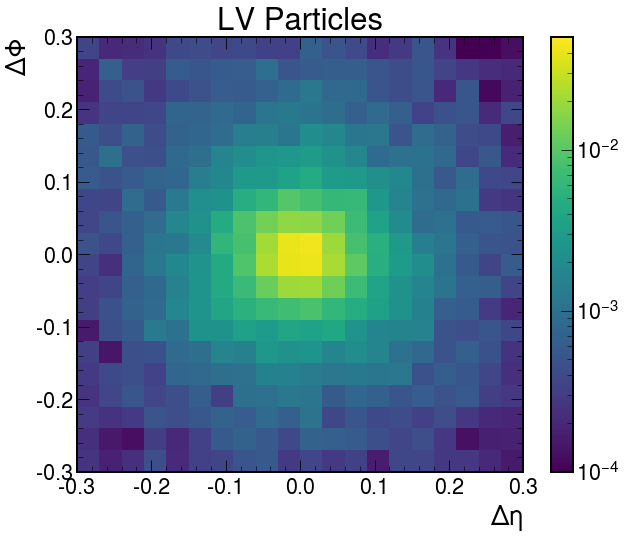

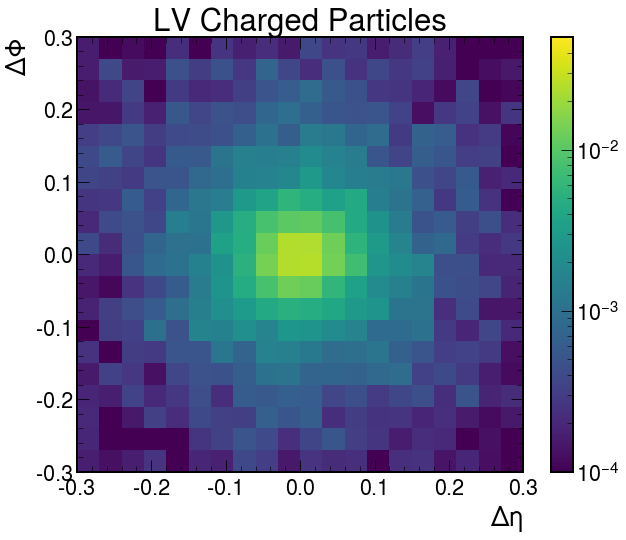

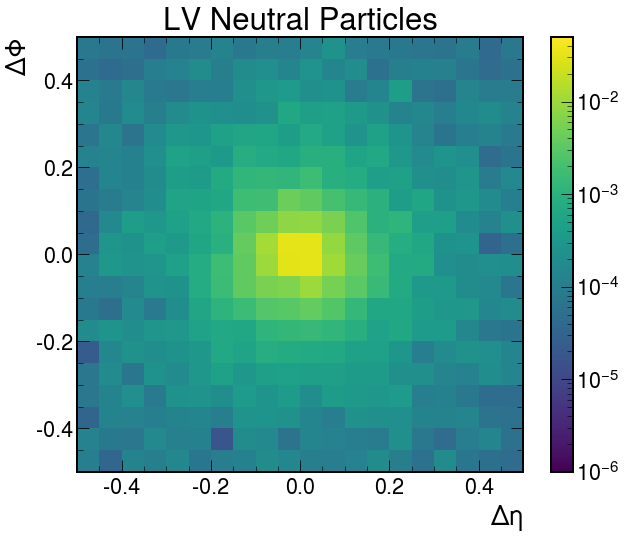

In [50]:
%matplotlib inline
plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(10,8))
a = plt.hist2d(eta_truths, phi_truths, bins=20, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_truth_scaled/njets, norm=mpl.colors.LogNorm())
plt.colorbar(a[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.clim(1e-4,5e-2)
plt.title('LV Particles')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.show()

fig = plt.figure(figsize=(10,8))
a = plt.hist2d(eta_truths[charge_truths==1], phi_truths[charge_truths==1], bins=20, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_truth_scaled[charge_truths==1]/njets, norm=mpl.colors.LogNorm())
plt.colorbar(a[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.clim(1e-4,5e-2)
plt.title('LV Charged Particles')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.show()

fig = plt.figure(figsize=(10,8))
a = plt.hist2d(eta_truths[charge_truths==0], phi_truths[charge_truths==0], bins=20, range=[[-0.5,0.5],[-0.5,0.5]], weights=pt_truth_scaled[charge_truths==0]/njets, norm=mpl.colors.LogNorm())
plt.colorbar(a[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.clim(1e-6,5e-2)
plt.title('LV Neutral Particles')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.show()




## LV plots

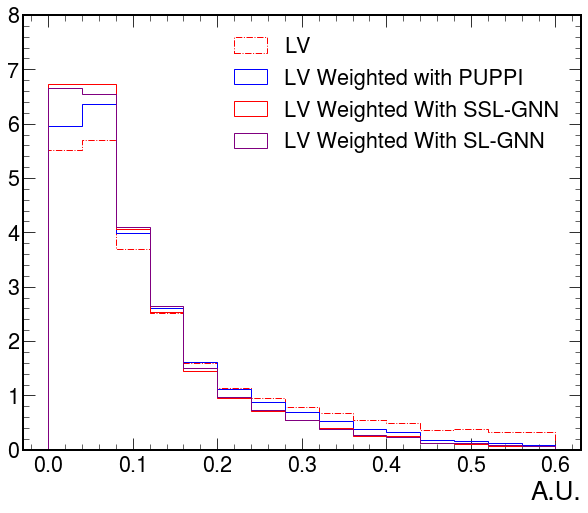

<Figure size 720x576 with 0 Axes>

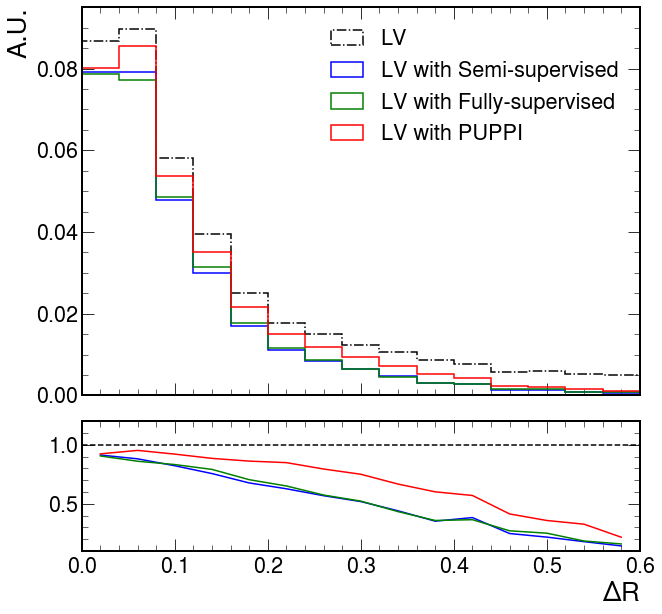

Truth LV sum:  0.3486800200317639
PUPPI PU sum:  0.3150577825938492
SSL-GNN sum:  0.28123568670437094
SL-GNN sum:  0.281801891101138


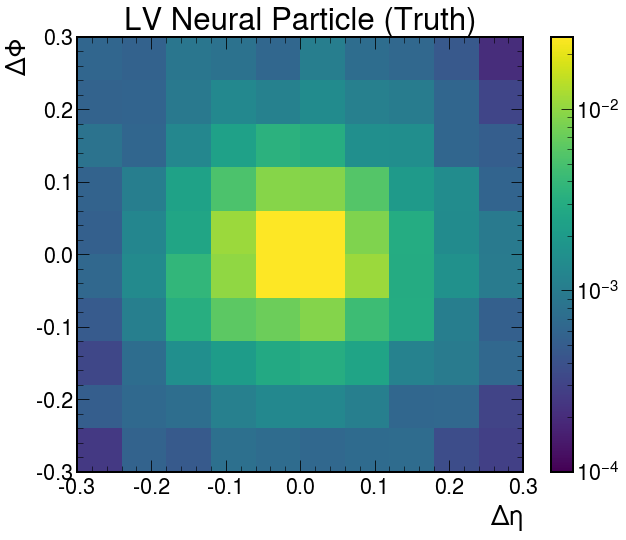

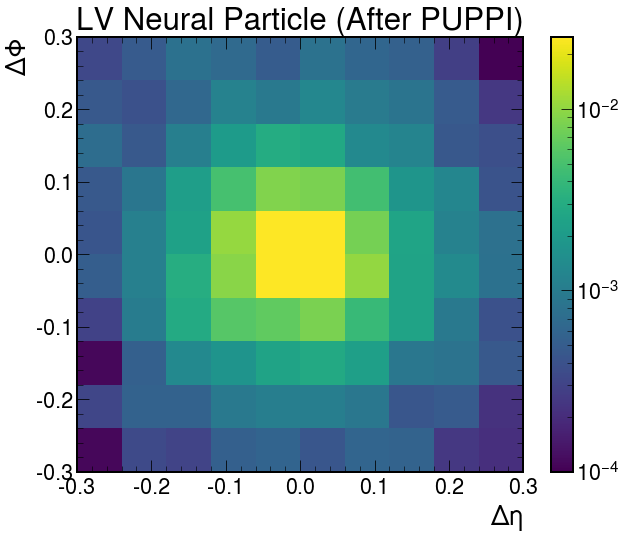

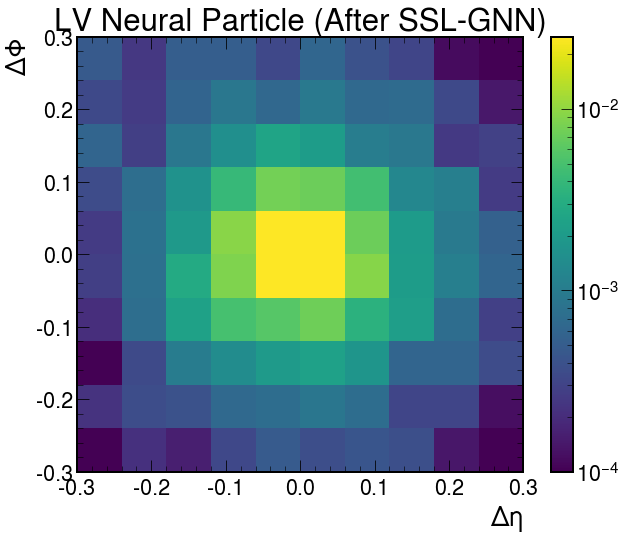

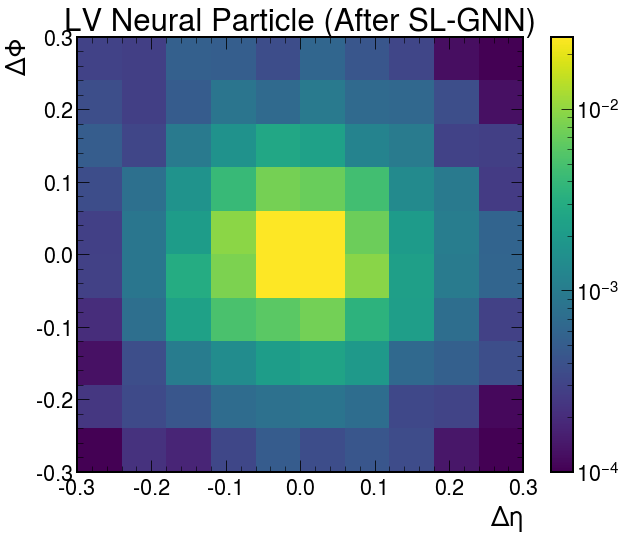

In [52]:
dR_truth = deltaRNew(eta_truths, phi_truths)
dR_lv    = deltaRNew(eta_lvs, phi_lvs)

%matplotlib inline
plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
#plt.hist(dR_truth, bins=20, range=(0,0.45), histtype='step', color='black', linestyle='-.', label=r'LV', density=True)
#plt.hist(dR_truth, bins=15, range=(0,0.45), histtype='step', color='black', weights=pt_truth_scaled, label=r'LV', density=True)
ax.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='red', linestyle='-.', label=r'LV', weights = pt_lv_scaled, density=True)
ax.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='b', linestyle='-',   weights = pt_lv_puppi_scaled, label=r'LV Weighted with PUPPI', density=True)
ax.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='red', linestyle='-', weights = pt_lv_pred_scaled,  label=r'LV Weighted With SSL-GNN', density=True)
ax.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='purple', linestyle='-', weights = pt_lv_predsl_scaled,  label=r'LV Weighted With SL-GNN', density=True)
ax.set_xlabel(r"$\Delta R$")
ax.set_xlabel('A.U.')
ax.set_ylim(0,8)
plt.legend()
plt.show()


fig = plt.figure(figsize=(10,8))
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.subplots_adjust(hspace=0.1)
vals, bins, _ = ax1.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='black', linestyle='-.', linewidth=1.5, label=r'LV', weights = pt_lv_scaled/njets, density=False)
vals_pred, bins, _ = ax1.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='blue', linestyle='-', linewidth=1.5, weights = pt_lv_pred_scaled/njets,  label=r'LV with Semi-supervised', density=False)
vals_predsl, bins, _ = ax1.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='green', linestyle='-', linewidth=1.5, weights = pt_lv_predsl_scaled/njets,  label=r'LV with Fully-supervised', density=False)
vals_puppi, bins, _ = ax1.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='red', linestyle='-', linewidth=1.5, weights = pt_lv_puppi_scaled/njets, label=r'LV with PUPPI', density=False)
ax1.set_ylabel('A.U.')
ax1.set_xlim(0,0.6)
ax1.set_ylim(0,0.095)
ax1.legend()
#plt.ylim(0,0.025)
ax2.plot((bins[:-1]+bins[1:])/2.0, vals_pred/vals, color='blue')
ax2.plot((bins[:-1]+bins[1:])/2.0, vals_predsl/vals, color='green')
ax2.plot((bins[:-1]+bins[1:])/2.0, vals_puppi/vals, color='red')
ax2.set_xlim(0,0.6)
ax2.set_xlabel(r"$\Delta R$")
ax2.set_ylim(0.1, 1.2)
ax2.axhline(y=1.0, color='black', linestyle='dashed')
plt.show()

#
#2d plots
#
fig = plt.figure(figsize=(10,8))
results_lv = plt.hist2d(eta_lvs, phi_lvs, bins=10, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_lv_scaled/njets, norm=mpl.colors.LogNorm())
plt.colorbar(results_lv[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.title('LV Neural Particle (Truth)')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.clim(1e-4,2.5e-2)
print("Truth LV sum: ", np.sum(results_lv[0]))

fig = plt.figure(figsize=(10,8))
results_puppi = plt.hist2d(eta_lvs, phi_lvs, bins=10, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_lv_puppi_scaled/njets, norm=mpl.colors.LogNorm())
plt.colorbar(results_puppi[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.title('LV Neural Particle (After PUPPI)')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.clim(1e-4,2.5e-2)
print("PUPPI PU sum: ", np.sum(results_puppi[0]))

fig = plt.figure(figsize=(10,8))
results_pred = plt.hist2d(eta_lvs, phi_lvs, bins=10, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_lv_pred_scaled/njets, norm=mpl.colors.LogNorm())
plt.colorbar(results_pred[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.title('LV Neural Particle (After SSL-GNN)')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.clim(1e-4,2.5e-2)
print("SSL-GNN sum: ", np.sum(results_pred[0]))

fig = plt.figure(figsize=(10,8))
results_predsl = plt.hist2d(eta_lvs, phi_lvs, bins=10, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_lv_predsl_scaled/njets, norm=mpl.colors.LogNorm())
plt.colorbar(results_predsl[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.title('LV Neural Particle (After SL-GNN)')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.clim(1e-4,2.5e-2)
print("SL-GNN sum: ", np.sum(results_predsl[0]))


In [112]:
(bins[:-1]+bins[1:])/2.0

array([0.015, 0.045, 0.075, 0.105, 0.135, 0.165, 0.195, 0.225, 0.255,
       0.285, 0.315, 0.345, 0.375, 0.405, 0.435])

In [93]:
def plot2D(results, legend, norm = results_lv, ymax=1.0, ymin=0.0):
    """
    plot the energy fraction ratio with respect to the gen level
    """
    xbins = results[1]
    ybins = results[2]
    vals = copy.deepcopy(results[0])
    if norm != None:
        vals /= norm[0]
    print(xbins)
    nbins_x = len(xbins) - 1
    nbins_y = len(ybins) -1
    wid_x = xbins[1]-xbins[0]
    wid_y = ybins[1]-ybins[0]
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(1,1,1)
    cmap = matplotlib.cm.coolwarm

    heatmap = ax.pcolorfast(xbins, ybins, vals, vmin = ymin, vmax=ymax, cmap=cmap)

    cbar = plt.colorbar(heatmap)
        
    for i in range(nbins_x):
        for j in range(nbins_y):
            ax.text(xbins[i]+wid_x/2, ybins[j]+wid_y/2, f"{vals[i][j]:.2f}", color='w',ha='center', va='center', fontsize=10)
    plt.xlabel(r'$\Delta\eta$')
    plt.ylabel(r'$\Delta\Phi$')
    plt.title(legend)
    

[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]
[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]
[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]
[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]
[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]
[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]


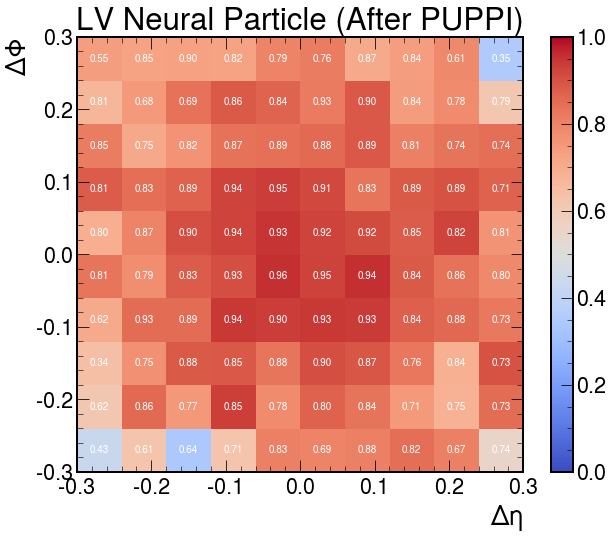

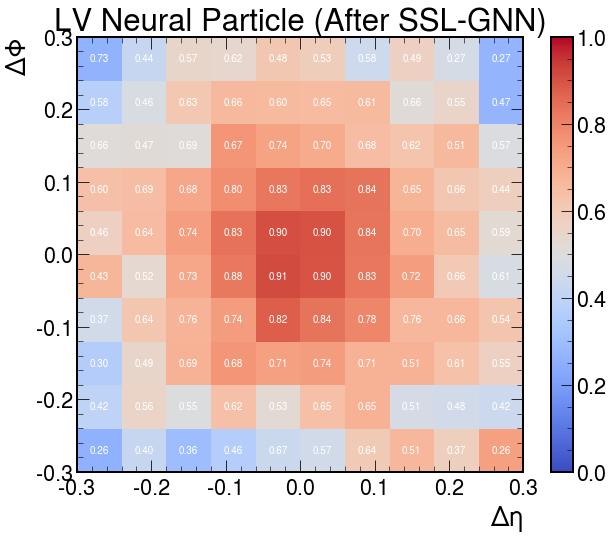

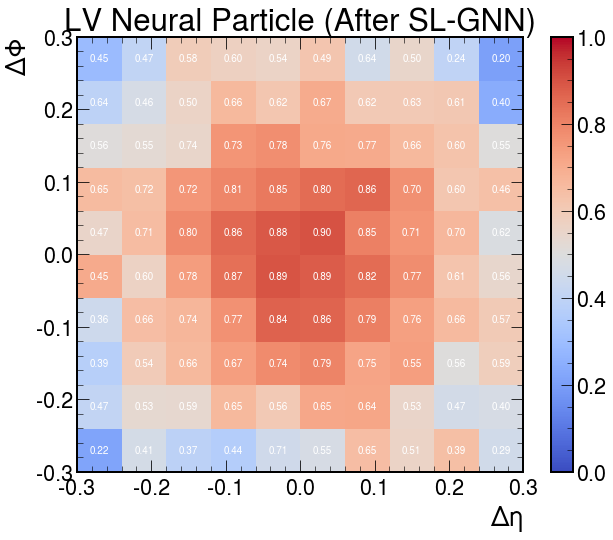

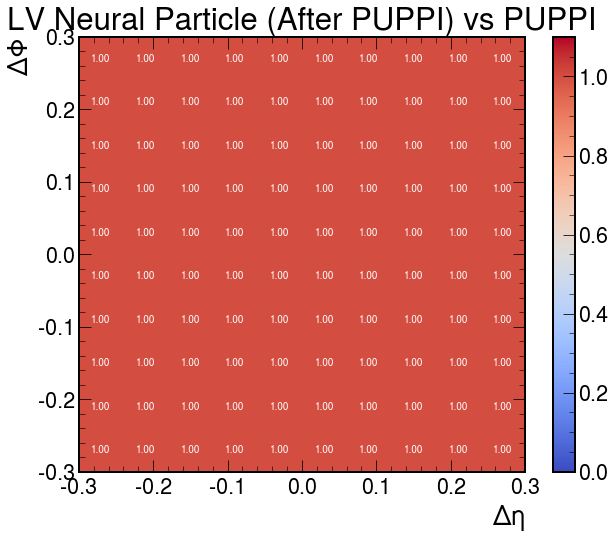

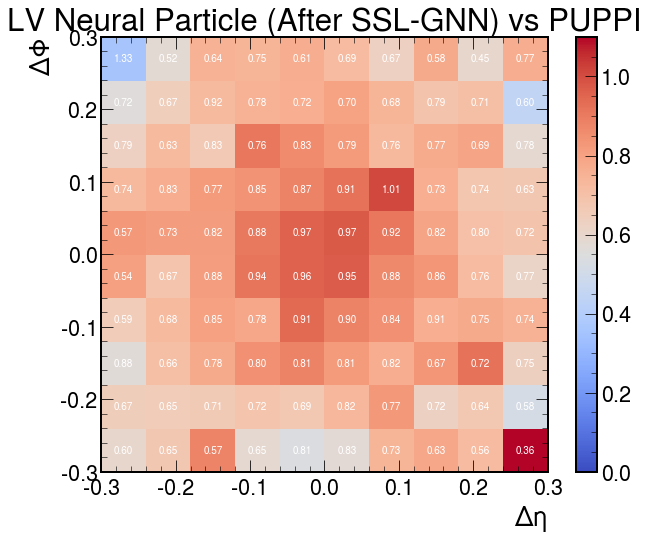

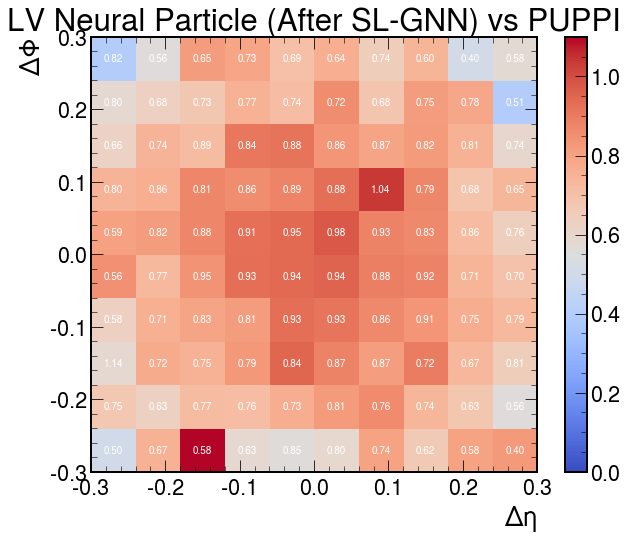

In [94]:
plot2D(results_puppi, "LV Neural Particle (After PUPPI)")
plot2D(results_pred,  "LV Neural Particle (After SSL-GNN)")
plot2D(results_predsl, "LV Neural Particle (After SL-GNN)")

plot2D(results_puppi, "LV Neural Particle (After PUPPI) vs PUPPI", results_puppi, 1.1)
plot2D(results_pred,  "LV Neural Particle (After SSL-GNN) vs PUPPI", results_puppi, 1.1)
plot2D(results_predsl, "LV Neural Particle (After SL-GNN) vs PUPPI", results_puppi, 1.1)

In [67]:
results_puppi[0]/results_lv[0]

array([[0.43258195, 0.62335022, 0.34085526, 0.62369746, 0.80708941,
        0.80074012, 0.80776263, 0.84619805, 0.80687687, 0.55270509],
       [0.61228167, 0.85513006, 0.75214767, 0.93310095, 0.78507617,
        0.87067495, 0.83264517, 0.74886691, 0.68180739, 0.85146189],
       [0.64114744, 0.77314137, 0.88294515, 0.89041141, 0.82901744,
        0.90494121, 0.89135287, 0.82470998, 0.68762612, 0.9009463 ],
       [0.70560158, 0.85038337, 0.84906788, 0.94371301, 0.93407446,
        0.94470842, 0.93916628, 0.87341517, 0.85562684, 0.8239108 ],
       [0.83144143, 0.7755569 , 0.87982998, 0.90253659, 0.95532471,
        0.92611661, 0.95498767, 0.8853893 , 0.83738533, 0.78583255],
       [0.69293335, 0.80040099, 0.90413951, 0.92504972, 0.9457262 ,
        0.92316568, 0.91023876, 0.87893084, 0.92570679, 0.76230473],
       [0.87982862, 0.84417018, 0.86891081, 0.92564125, 0.93509109,
        0.91511889, 0.82973247, 0.88573261, 0.9002035 , 0.86750618],
       [0.81510289, 0.70817784, 0.7641777

## make the ration of the PU momentum distributions after different mitigations

In [40]:
dR_truth = deltaRNew(eta_truths, phi_truths)
dR_pu    = deltaRNew(eta_pus, phi_pus)

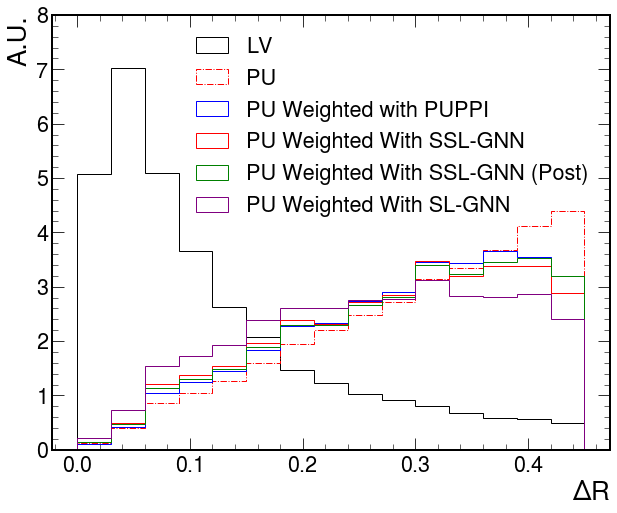

<Figure size 720x576 with 0 Axes>

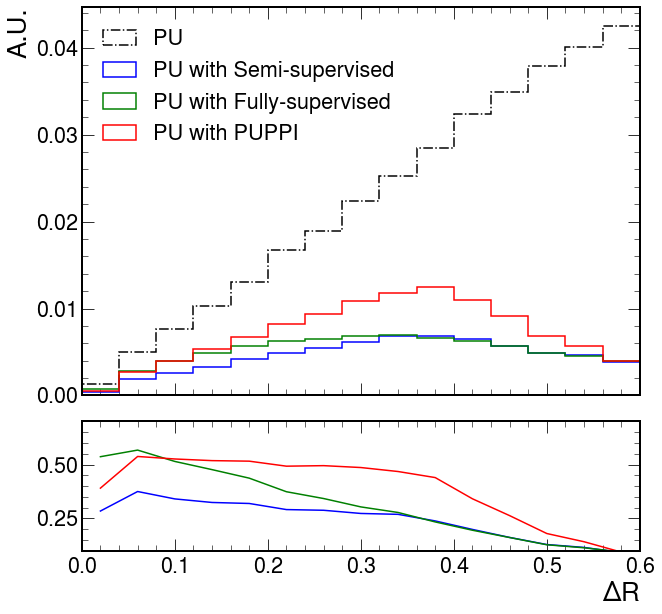

In [53]:
fig = plt.figure(figsize=(10,8))
#plt.hist(dR_truth, bins=20, range=(0,0.45), histtype='step', color='black', linestyle='-.', label=r'LV', density=True)
plt.hist(dR_truth, bins=15, range=(0,0.45), histtype='step', color='black', weights=pt_truth_scaled, label=r'LV', density=True)
plt.hist(dR_pu,    bins=15, range=(0,0.45), histtype='step', color='red', linestyle='-.', label=r'PU', weights = pt_pu_scaled, density=True)
plt.hist(dR_pu,    bins=15, range=(0,0.45), histtype='step', color='b', linestyle='-',   weights = pt_pu_puppi_scaled, label=r'PU Weighted with PUPPI', density=True)
plt.hist(dR_pu,    bins=15, range=(0,0.45), histtype='step', color='red', linestyle='-', weights = pt_pu_pred_scaled,  label=r'PU Weighted With SSL-GNN', density=True)
plt.hist(dR_pu,    bins=15, range=(0,0.45), histtype='step', color='green', linestyle='-', weights = pt_pu_pred_post_scaled,  label=r'PU Weighted With SSL-GNN (Post)', density=True)
plt.hist(dR_pu,    bins=15, range=(0,0.45), histtype='step', color='purple', linestyle='-', weights = pt_pu_predsl_scaled,  label=r'PU Weighted With SL-GNN', density=True)
plt.xlabel(r"$\Delta R$")
plt.ylabel('A.U.')
plt.ylim(0,8)
plt.legend()
plt.show()

"""
fig = plt.figure(figsize=(10,8))
#plt.hist(dR_truth, bins=20, range=(0,0.45), histtype='step', color='black', linestyle='-.', label=r'LV', density=True)
#plt.hist(dR_truth, bins=15, range=(0,0.45), histtype='step', color='black', weights=pt_truth_scaled/njets, label=r'LV', density=False)
plt.hist(dR_pu,    bins=15, range=(0,0.45), histtype='step', color='red', linestyle='-.', label=r'PU', weights = pt_pu_scaled/njets, density=False)
plt.hist(dR_pu,    bins=15, range=(0,0.45), histtype='step', color='b', linestyle='-',   weights = pt_pu_puppi_scaled/njets, label=r'PU Weighted with PUPPI', density=False)
plt.hist(dR_pu,    bins=15, range=(0,0.45), histtype='step', color='red', linestyle='-', weights = pt_pu_pred_scaled/njets,  label=r'PU Weighted With SSL-GNN', density=False)
plt.hist(dR_pu,    bins=15, range=(0,0.45), histtype='step', color='purple', linestyle='-', weights = pt_pu_predsl_scaled/njets,  label=r'PU Weighted With SL-GNN', density=False)
plt.xlabel(r"$\Delta R$")
plt.ylabel('A.U.')
plt.ylim(0,0.025)
plt.legend()
plt.show()
"""

fig = plt.figure(figsize=(10,8))
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.subplots_adjust(hspace=0.1)
vals, bins, _        = ax1.hist(dR_pu,    bins=15, range=(0,0.6), histtype='step', color='black', linestyle='-.', linewidth=1.5, label=r'PU', weights = pt_pu_scaled/njets, density=False)
vals_pred, bins, _   = ax1.hist(dR_pu,    bins=15, range=(0,0.6), histtype='step', color='blue', linestyle='-', linewidth=1.5, weights = pt_pu_pred_scaled/njets,  label=r'PU with Semi-supervised', density=False)
#vals_pred_post, bins, _   = ax1.hist(dR_pu,    bins=15, range=(0,0.45), histtype='step', color='green', linestyle='-', weights = pt_pu_pred_post_scaled/njets,  label=r'PU Weighted With SSL-GNN (Post)', density=False)
vals_predsl, bins, _ = ax1.hist(dR_pu,    bins=15, range=(0,0.6), histtype='step', color='green', linestyle='-', linewidth=1.5, weights = pt_pu_predsl_scaled/njets,  label=r'PU with Fully-supervised', density=False)
vals_puppi, bins, _  = ax1.hist(dR_pu,    bins=15, range=(0,0.6), histtype='step', color='red', linestyle='-', linewidth=1.5,  weights = pt_pu_puppi_scaled/njets, label=r'PU with PUPPI', density=False)
ax1.set_ylabel('A.U.')
ax1.set_xlim(0,0.6)
ax1.legend(loc='upper left')
#plt.ylim(0,0.025)
ax2.plot((bins[:-1]+bins[1:])/2.0, vals_pred/vals, color='blue')
#ax2.plot((bins[:-1]+bins[1:])/2.0, vals_pred_post/vals, color='green')
ax2.plot((bins[:-1]+bins[1:])/2.0, vals_predsl/vals, color='green')
ax2.plot((bins[:-1]+bins[1:])/2.0, vals_puppi/vals, color='red')
ax2.set_xlim(0,0.6)
ax2.set_xlabel(r"$\Delta R$")
ax2.set_ylim(0.1, 0.7)
plt.show()



PU sum:  0.10668450010565117
PUPPI PU sum:  0.05323468315765263
SSL-GNN sum:  0.031892613744815446
SL-GNN sum:  0.04056808908034677


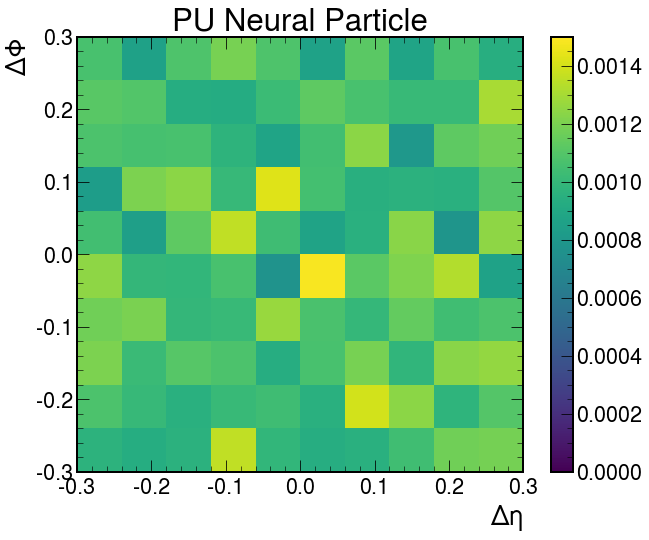

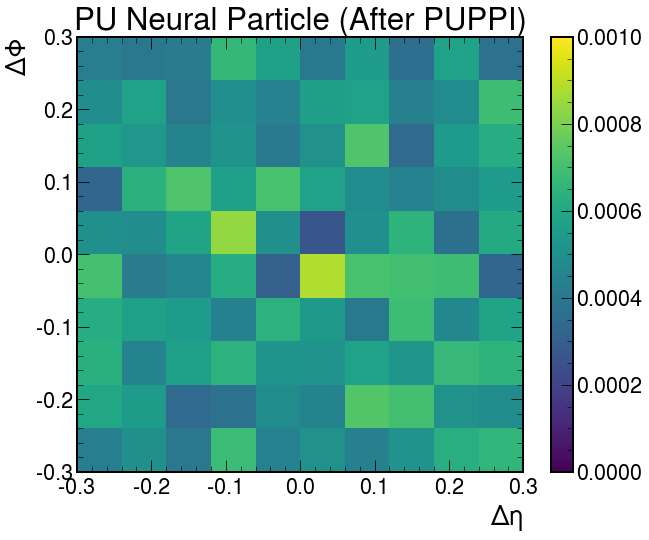

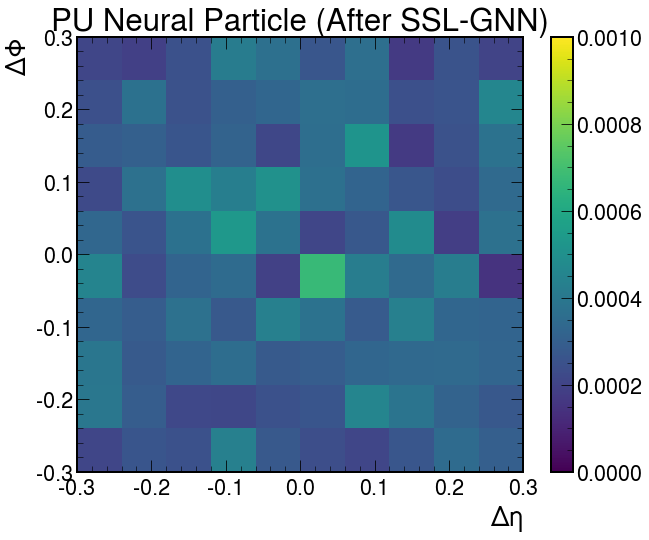

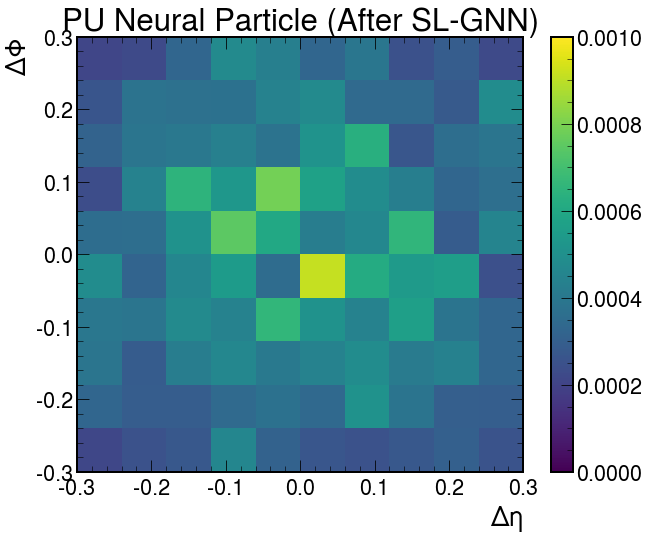

In [59]:
fig = plt.figure(figsize=(10,8))
results_pu = plt.hist2d(eta_pus, phi_pus, bins=10, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_pu_scaled/njets)
plt.colorbar(results_pu[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.title('PU Neural Particle')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.clim(0,1.5e-3)
print("PU sum: ", np.sum(results_pu[0]))

fig = plt.figure(figsize=(10,8))
results_pu_puppi = plt.hist2d(eta_pus, phi_pus, bins=10, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_pu_puppi_scaled/njets)
plt.colorbar(results_pu_puppi[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.title('PU Neural Particle (After PUPPI)')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.clim(0,1.0e-3)
print("PUPPI PU sum: ", np.sum(results_pu_puppi[0]))

fig = plt.figure(figsize=(10,8))
results_pu_pred = plt.hist2d(eta_pus, phi_pus, bins=10, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_pu_pred_scaled/njets)
plt.colorbar(results_pu_pred[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.title('PU Neural Particle (After SSL-GNN)')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.clim(0,1.0e-3)
print("SSL-GNN sum: ", np.sum(results_pu_pred[0]))

fig = plt.figure(figsize=(10,8))
results_pu_predsl = plt.hist2d(eta_pus, phi_pus, bins=10, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_pu_predsl_scaled/njets)
plt.colorbar(results_pu_predsl[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.title('PU Neural Particle (After SL-GNN)')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.clim(0,1.0e-3)
print("SL-GNN sum: ", np.sum(results_pu_predsl[0]))


[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]
[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]
[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]
[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]
[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]
[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]


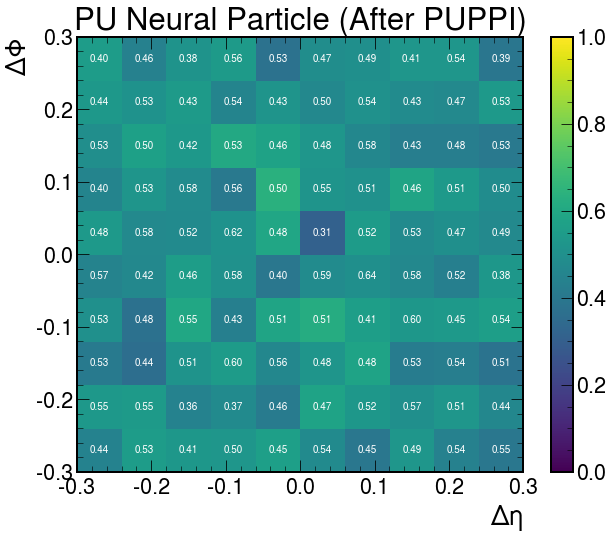

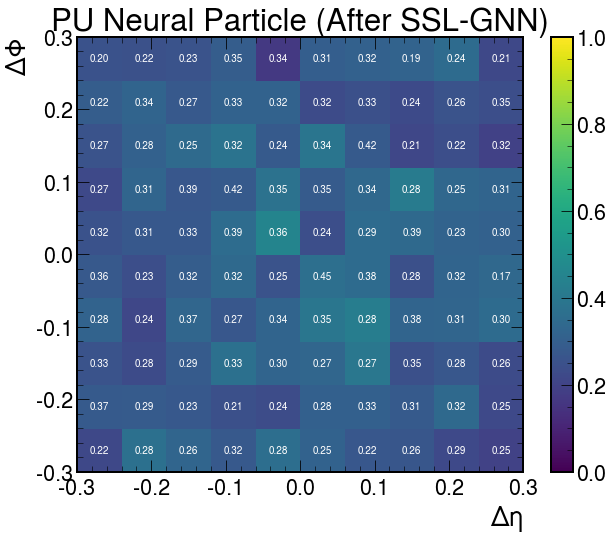

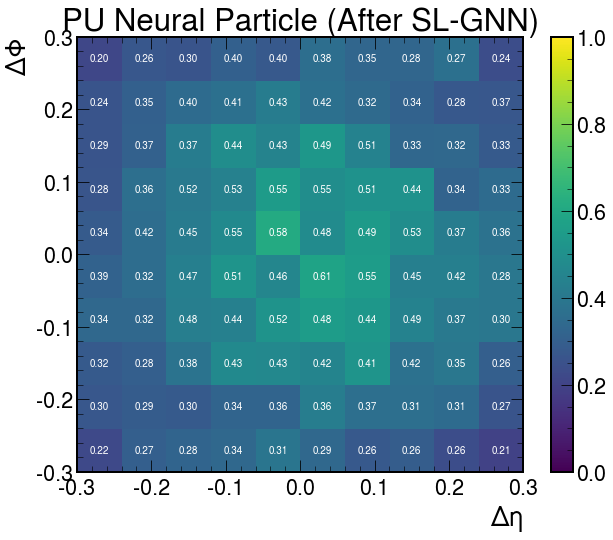

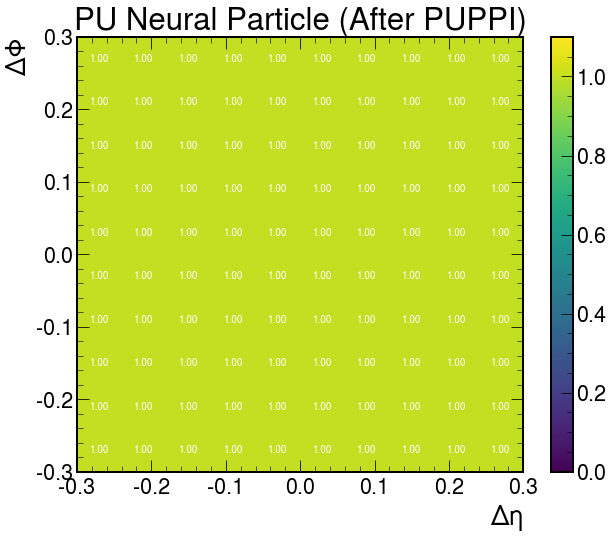

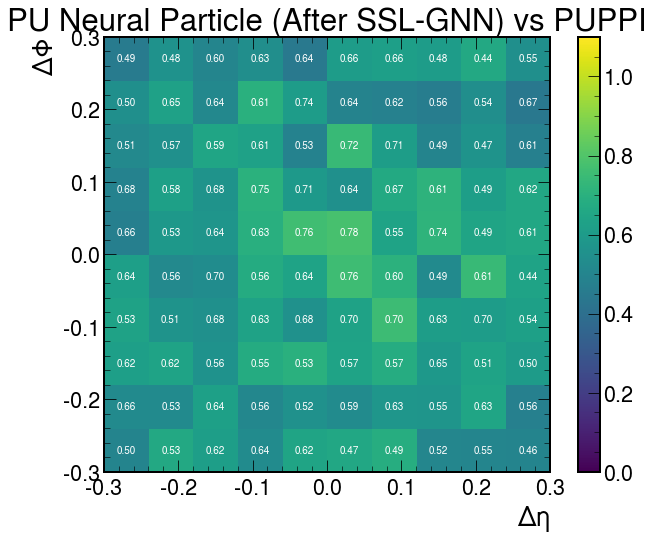

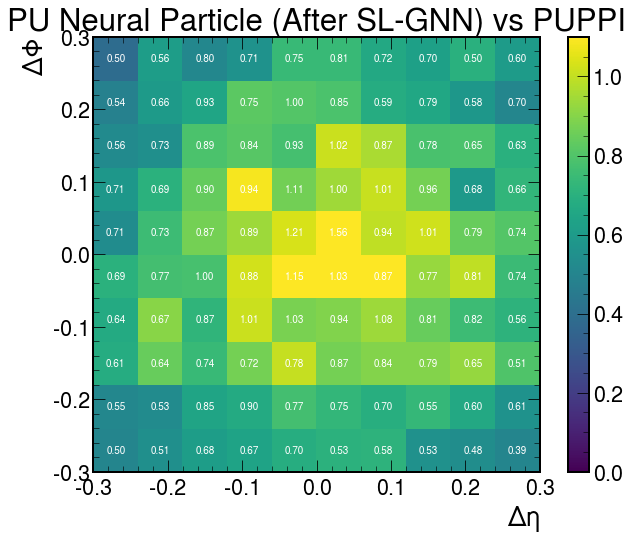

In [61]:
plot2D(results_pu_puppi,   "PU Neural Particle (After PUPPI)", results_pu)
plot2D(results_pu_pred,    "PU Neural Particle (After SSL-GNN)", results_pu)
plot2D(results_pu_predsl,  "PU Neural Particle (After SL-GNN)", results_pu)

plot2D(results_pu_puppi,   "PU Neural Particle (After PUPPI)", results_pu_puppi,1.1)
plot2D(results_pu_pred,    "PU Neural Particle (After SSL-GNN) vs PUPPI", results_pu_puppi, 1.1)
plot2D(results_pu_predsl,  "PU Neural Particle (After SL-GNN) vs PUPPI", results_pu_puppi, 1.1)

## check the effects of both LV and PU

In [73]:
eta_alls = np.concatenate([eta_lvs, eta_pus],axis=0)
phi_alls = np.concatenate([phi_lvs, phi_pus],axis=0)
pt_pu_scaled_truth = np.zeros(pt_pu_scaled.shape[0])
pt_all_truth = np.concatenate([pt_lv_scaled, pt_pu_scaled_truth],axis=0)
# without any cleaning
pt_all_default = np.concatenate([pt_lv_scaled, pt_pu_scaled],axis=0)
pt_all_puppi = np.concatenate([pt_lv_puppi_scaled, pt_pu_puppi_scaled],axis=0)
pt_all_pred = np.concatenate([pt_lv_pred_scaled, pt_pu_pred_scaled],axis=0)
pt_all_predsl = np.concatenate([pt_lv_predsl_scaled, pt_pu_predsl_scaled],axis=0)

In [129]:
dR_all = np.concatenate([dR_lv, dR_pu], axis=0)

<Figure size 720x576 with 0 Axes>

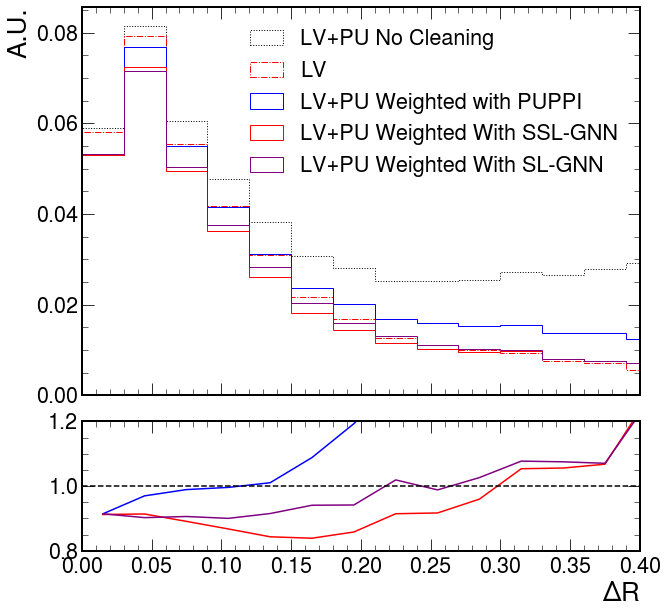

In [142]:
fig = plt.figure(figsize=(10,8))
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex=True, gridspec_kw={'height_ratios': [3, 1]})
fig.subplots_adjust(hspace=0.1)
vals_default, bins, _  = ax1.hist(dR_all,    bins=15, range=(0,0.45), histtype='step', color='black', linestyle='dotted',   weights = pt_all_default/njets, label=r'LV+PU No Cleaning', density=False)
vals, bins, _        = ax1.hist(dR_all,    bins=15, range=(0,0.45), histtype='step', color='red', linestyle='-.', label=r'LV', weights = pt_all_truth/njets, density=False)
vals_puppi, bins, _  = ax1.hist(dR_all,    bins=15, range=(0,0.45), histtype='step', color='b', linestyle='-',   weights = pt_all_puppi/njets, label=r'LV+PU Weighted with PUPPI', density=False)
vals_pred, bins, _   = ax1.hist(dR_all,    bins=15, range=(0,0.45), histtype='step', color='red', linestyle='-', weights = pt_all_pred/njets,  label=r'LV+PU Weighted With SSL-GNN', density=False)
vals_predsl, bins, _ = ax1.hist(dR_all,    bins=15, range=(0,0.45), histtype='step', color='purple', linestyle='-', weights = pt_all_predsl/njets,  label=r'LV+PU Weighted With SL-GNN', density=False)
ax1.set_ylabel('A.U.')
ax1.set_xlim(0,0.4)
ax1.legend()
#plt.ylim(0,0.025)
ax2.plot((bins[:-1]+bins[1:])/2.0, vals_puppi/vals, color='b')
ax2.plot((bins[:-1]+bins[1:])/2.0, vals_pred/vals, color='red')
ax2.plot((bins[:-1]+bins[1:])/2.0, vals_predsl/vals, color='purple')
ax2.set_xlim(0,0.4)
ax2.set_xlabel(r"$\Delta R$")
ax2.set_ylim(0.8, 1.2)
ax2.axhline(y=1.0, color='black', linestyle='dashed')
plt.show()

PU sum:  0.3486800200317639
PU sum:  0.4553645201374152
PU sum:  0.3682924657515019
PU sum:  0.31296472267859954
PU sum:  0.32298570526172543
[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]
[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]
[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]
[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]
[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]
[-0.3  -0.24 -0.18 -0.12 -0.06  0.    0.06  0.12  0.18  0.24  0.3 ]


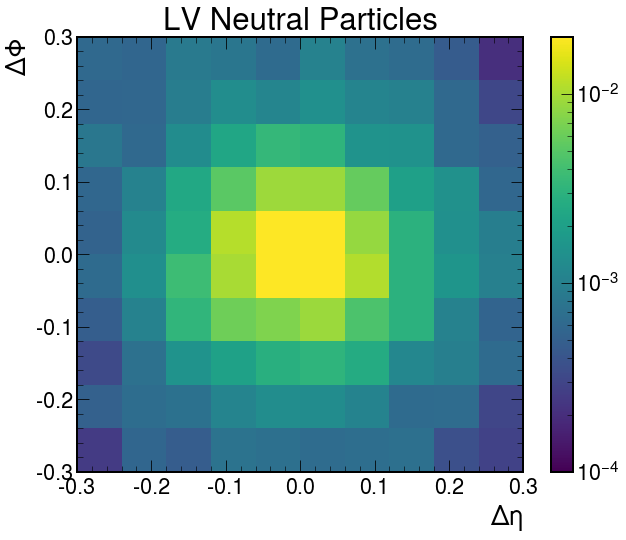

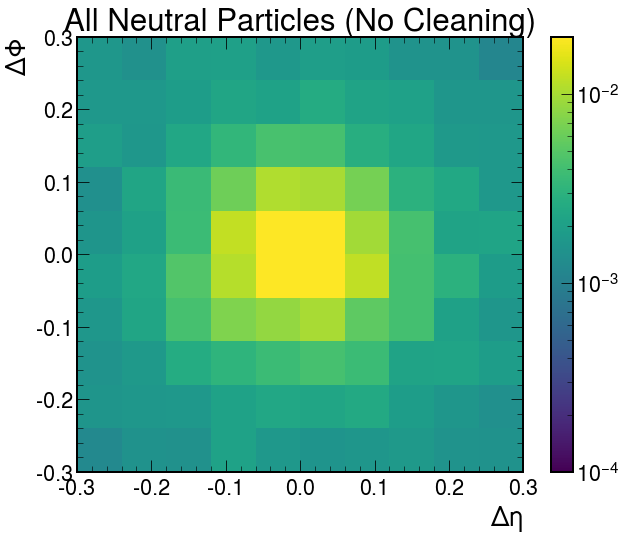

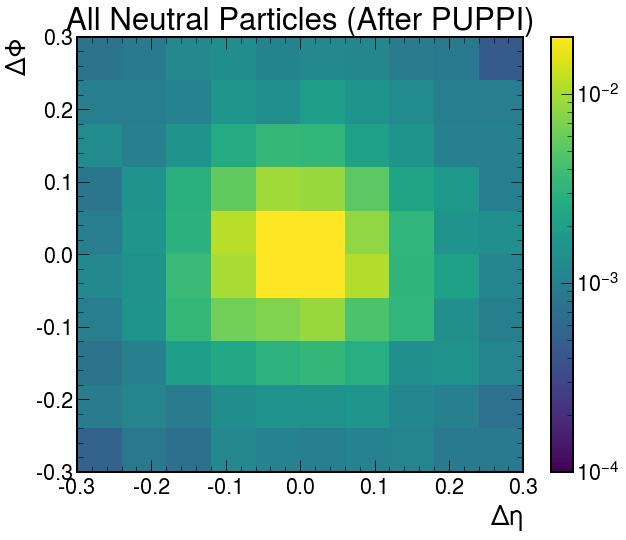

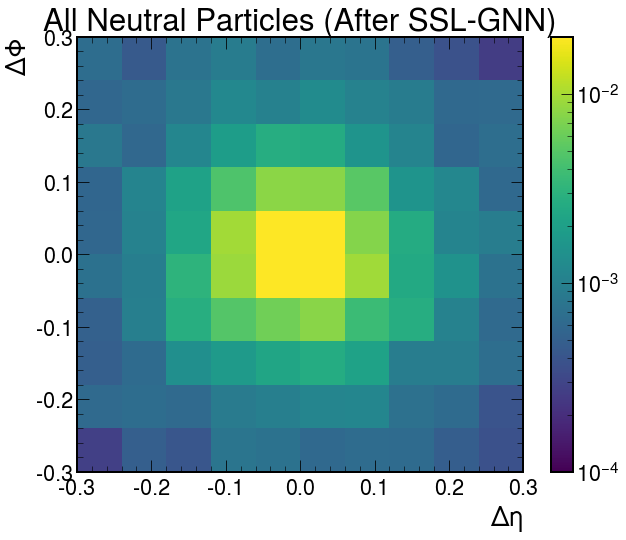

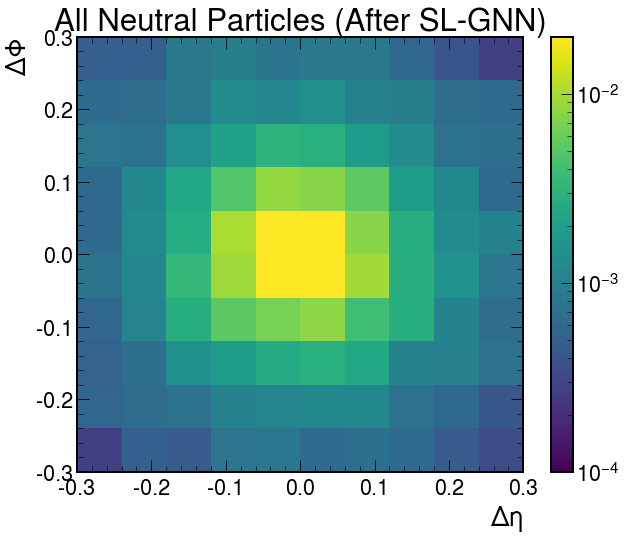

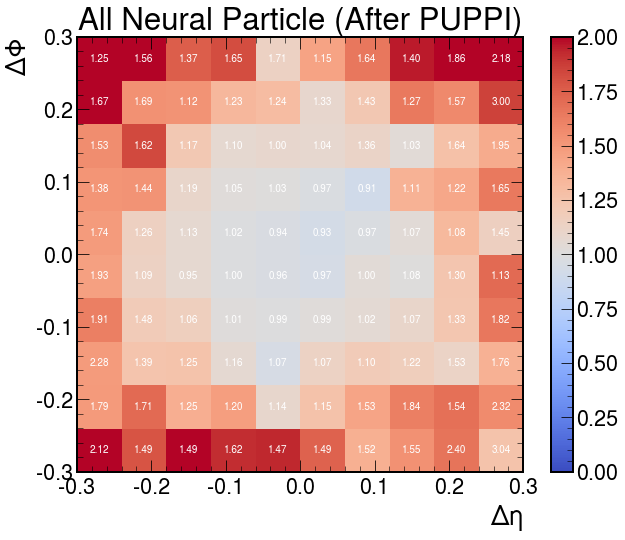

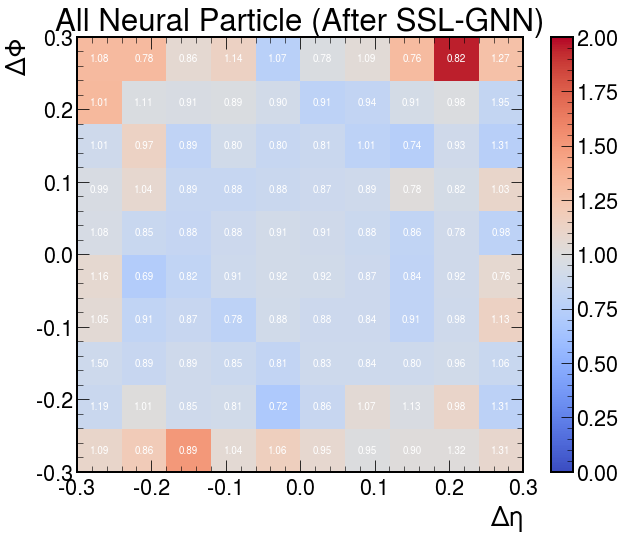

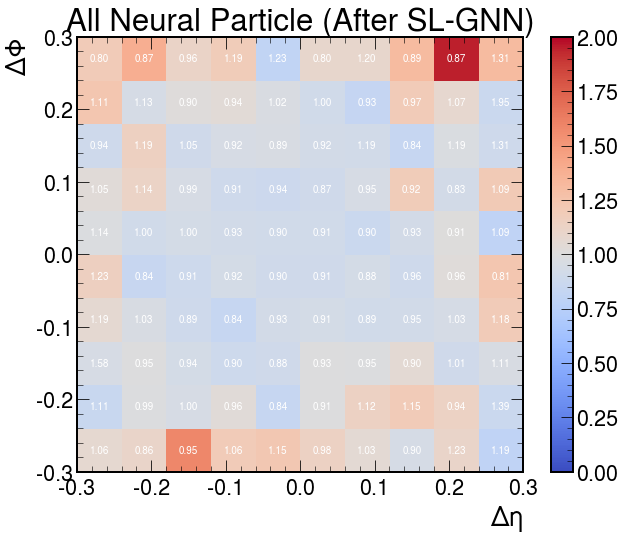

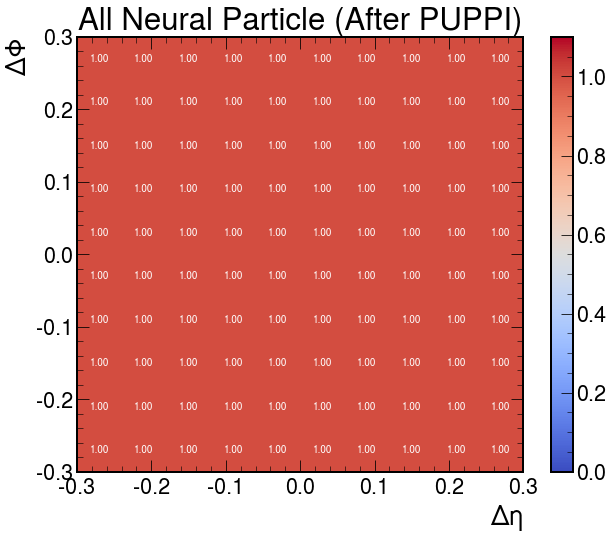

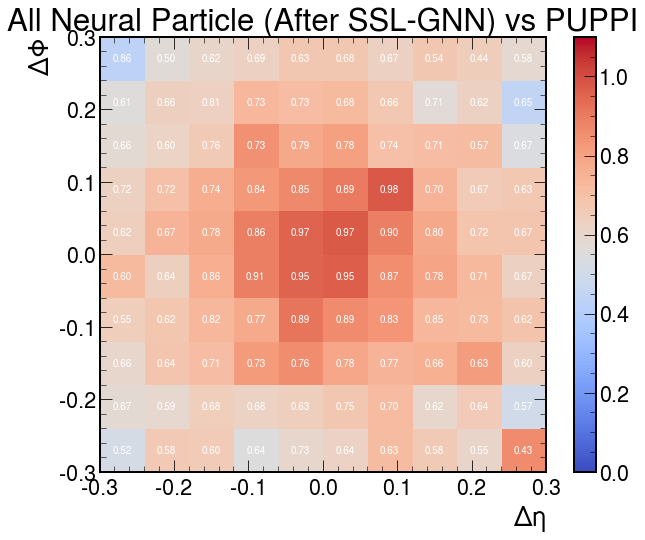

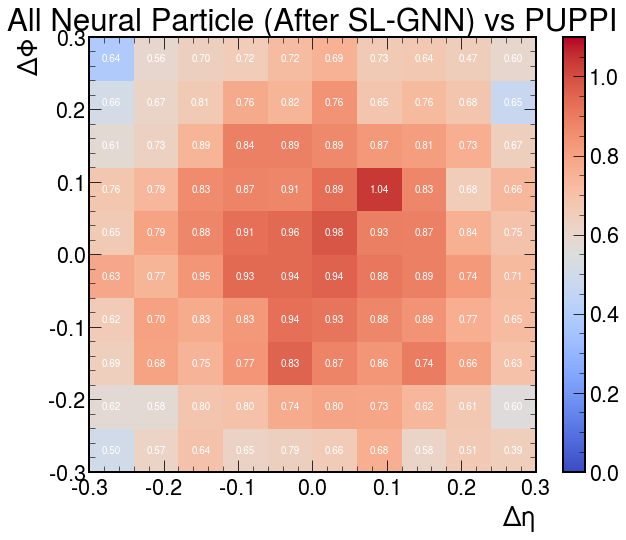

In [97]:
def makeplot(weights, legend):
    fig = plt.figure(figsize=(10,8))
    results = plt.hist2d(eta_alls, phi_alls, bins=10, range=[[-0.3,0.3],[-0.3,0.3]], weights=weights/njets, norm=mpl.colors.LogNorm())
    plt.colorbar(results[3])
    #plt.xlim(-4.0,4.0)
    #plt.xscale('log')
    #plt.zscale('log')
    plt.title(legend)
    plt.xlabel(r'$\Delta\eta$')
    plt.ylabel(r'$\Delta\Phi$')
    plt.clim(1e-4,2e-2)
    print("PU sum: ", np.sum(results[0]))
    return results

results_all_truth   = makeplot(pt_all_truth,     "LV Neutral Particles")
results_all_default = makeplot(pt_all_default, "All Neutral Particles (No Cleaning)")
results_all_puppi   = makeplot(pt_all_puppi,   "All Neutral Particles (After PUPPI)")
results_all_pred    = makeplot(pt_all_pred,    "All Neutral Particles (After SSL-GNN)")
results_all_predsl  = makeplot(pt_all_predsl,  "All Neutral Particles (After SL-GNN)")

plot2D(results_all_puppi,   "All Neural Particle (After PUPPI)", results_all_truth, 2.0, 0.0)
plot2D(results_all_pred,    "All Neural Particle (After SSL-GNN)", results_all_truth, 2.0, 0.0)
plot2D(results_all_predsl,  "All Neural Particle (After SL-GNN)", results_all_truth, 2.0, 0.0)

plot2D(results_all_puppi,   "All Neural Particle (After PUPPI)", results_all_puppi,1.1)
plot2D(results_all_pred,    "All Neural Particle (After SSL-GNN) vs PUPPI", results_all_puppi, 1.1)
plot2D(results_all_predsl,  "All Neural Particle (After SL-GNN) vs PUPPI", results_all_puppi, 1.1)


In [84]:
results_all_truth

(array([[0.00025204, 0.00050978, 0.00032633, 0.00048   , 0.00062546,
         0.00053355, 0.00056907, 0.00082537, 0.00056452, 0.00060327],
        [0.00056238, 0.0006453 , 0.00070652, 0.00105661, 0.0013692 ,
         0.00124897, 0.00104389, 0.00060531, 0.00057389, 0.00056054],
        [0.00046865, 0.00072259, 0.00152636, 0.00318561, 0.00378697,
         0.00258944, 0.00241317, 0.00128933, 0.00092216, 0.00087791],
        [0.00074673, 0.00109491, 0.00205877, 0.00623411, 0.00996893,
         0.01099512, 0.00519561, 0.00231298, 0.00131679, 0.00080213],
        [0.00069483, 0.0013271 , 0.00280316, 0.00717158, 0.03599324,
         0.03781552, 0.0091194 , 0.00340805, 0.00110947, 0.00062066],
        [0.00063149, 0.00129666, 0.00311514, 0.00896346, 0.04105105,
         0.03875667, 0.00902372, 0.00315071, 0.00140143, 0.00104926],
        [0.0006707 , 0.00106866, 0.0025337 , 0.0044267 , 0.0108525 ,
         0.00858594, 0.00571555, 0.00152375, 0.00108672, 0.00070098],
        [0.0006957 , 0.0006

In [86]:
results_lv

(array([[0.00025204, 0.00050978, 0.00032633, 0.00048   , 0.00062546,
         0.00053355, 0.00056907, 0.00082537, 0.00056452, 0.00060327],
        [0.00056238, 0.0006453 , 0.00070652, 0.00105661, 0.0013692 ,
         0.00124897, 0.00104389, 0.00060531, 0.00057389, 0.00056054],
        [0.00046865, 0.00072259, 0.00152636, 0.00318561, 0.00378697,
         0.00258944, 0.00241317, 0.00128933, 0.00092216, 0.00087791],
        [0.00074673, 0.00109491, 0.00205877, 0.00623411, 0.00996893,
         0.01099512, 0.00519561, 0.00231298, 0.00131679, 0.00080213],
        [0.00069483, 0.0013271 , 0.00280316, 0.00717158, 0.03599324,
         0.03781552, 0.0091194 , 0.00340805, 0.00110947, 0.00062066],
        [0.00063149, 0.00129666, 0.00311514, 0.00896346, 0.04105105,
         0.03875667, 0.00902372, 0.00315071, 0.00140143, 0.00104926],
        [0.0006707 , 0.00106866, 0.0025337 , 0.0044267 , 0.0108525 ,
         0.00858594, 0.00571555, 0.00152375, 0.00108672, 0.00070098],
        [0.0006957 , 0.0006

make the event display

In [75]:
import matplotlib.pyplot as plt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [103]:
iters = iter(data)
for i in range(37):
    res = iters.next()
res = iters.next()

res_gpu = res.to(device)
model_gated_boost.to('cuda:0')
model_gated_boost.eval()

model_gated_boost.eval()
pred_gpu = model_gated_boost.forward(res_gpu)
pred = np.array(pred_gpu[0][:,0].cpu().detach())

model_gated_boost_sp.to('cuda:0')
model_gated_boost_sp.eval()
pred_gpu_sp = model_gated_boost_sp.forward(res_gpu)
pred_sp = np.array(pred_gpu_sp[0][:,0].cpu().detach())

pt  = np.array(res.x[:,2].cpu().detach())
eta = np.array(res.x[:,0].cpu().detach())
phi = np.array(res.x[:,1].cpu().detach())
selection = (phi < 0)
phi[selection] = (phi[selection] + 2*np.pi)

puppi = np.array(res.x[:,res.num_feature_actual[0].item()-1].cpu().detach())
truth = np.array(res.y.cpu().detach())

charge_index = res.Charge_index[0]
charge = np.zeros(pt.shape[0])
charge[charge_index] = 1

# apply pt > 0.5 cut
ptcut = 1.0
eta = eta[pt>ptcut]
phi = phi[pt>ptcut]
puppi = puppi[pt>ptcut]
truth = truth[pt>ptcut]
charge = charge[pt>ptcut]
pred = pred[pt>ptcut]
pred_sp = pred_sp[pt>ptcut]
pt = pt[pt>ptcut]

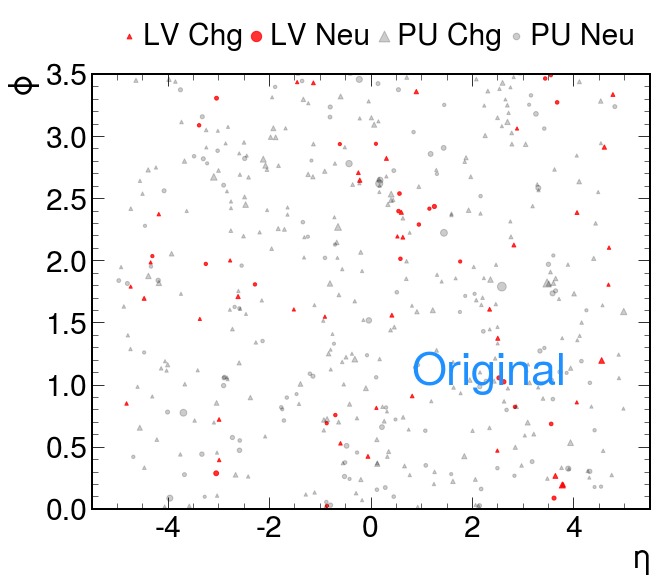

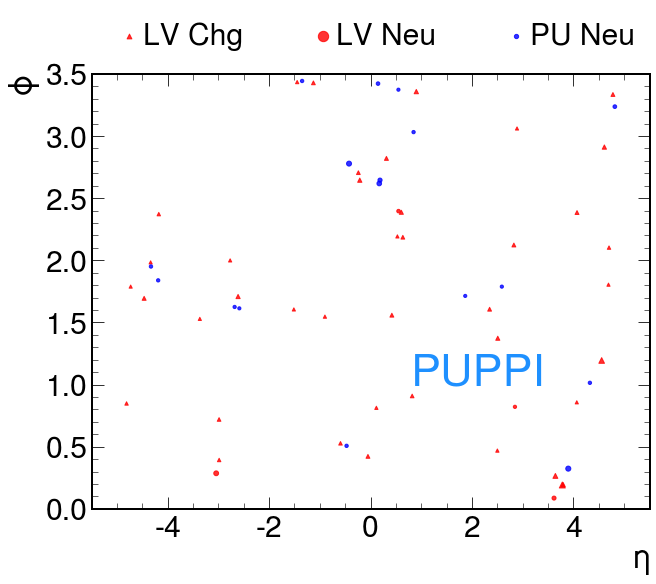

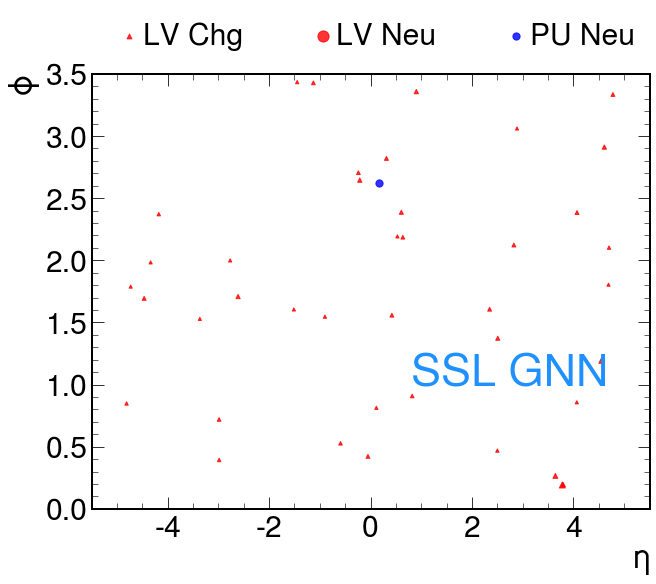

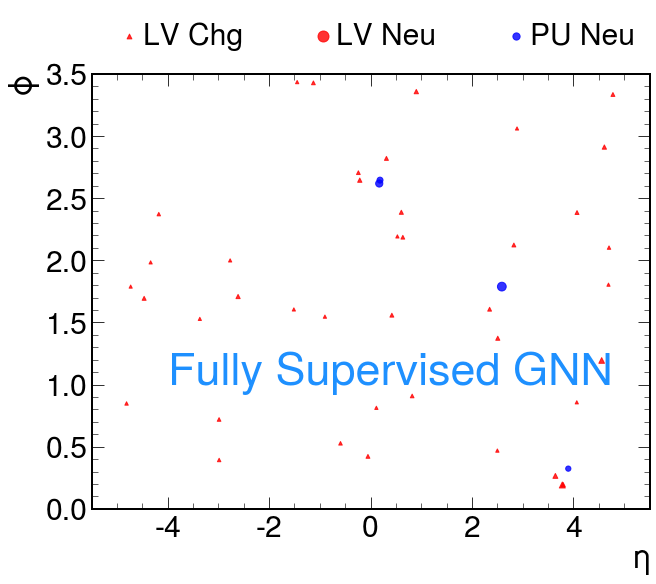

In [104]:
#
# truth
#
eta_chg_PU = eta[(truth==0) & (charge!=0)]
phi_chg_PU = phi[(truth==0) & (charge!=0)]
pt_chg_PU  = pt [(truth==0) & (charge!=0)]
eta_neu_PU = eta[(truth==0) & (charge==0)]
phi_neu_PU = phi[(truth==0) & (charge==0)]
pt_neu_PU  = pt [(truth==0) & (charge==0)]

eta_chg_LV = eta[(truth==1) & (charge!=0)]
phi_chg_LV = phi[(truth==1) & (charge!=0)]
pt_chg_LV  = pt [(truth==1) & (charge!=0)]
eta_neu_LV = eta[(truth==1) & (charge==0)]
phi_neu_LV = phi[(truth==1) & (charge==0)]
pt_neu_LV  = pt [(truth==1) & (charge==0)]

#print("pt chg PU", pt_chg_PU)
#print("pt chg LV", pt_chg_LV)

#print("PUPPI weights", puppi)
ymin = 0.0
ymax = 3.5

%matplotlib inline
plt.style.use(hep.style.ROOT)
SMALL_SIZE = 30
MEDIUM_SIZE = 32
BIGGER_SIZE = 34
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
#plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('legend', handletextpad=-0.3)

fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
#ax.scatter(eta_chg_PU, phi_chg_PU,  s=pt_chg_PU*10,   c='black', alpha=0.2, label='PU Chg', marker='^')
#ax.scatter(eta_neu_PU, phi_neu_PU,  s=pt_neu_PU*10,   c='black', alpha=0.2, label='PU Neu', marker='o')
ax.scatter(eta_chg_LV, phi_chg_LV,  s=pt_chg_LV*10,   c='red', alpha=0.8, label='LV Chg', marker='^')
ax.scatter(eta_neu_LV, phi_neu_LV,  s=pt_neu_LV*10,   c='red', alpha=0.8, label='LV Neu', marker='o')
ax.scatter(eta_chg_PU, phi_chg_PU,  s=pt_chg_PU*10,   c='black', alpha=0.2, label='PU Chg', marker='^')
ax.scatter(eta_neu_PU, phi_neu_PU,  s=pt_neu_PU*10,   c='black', alpha=0.2, label='PU Neu', marker='o')
ax.set_ylabel(r'$\phi$')
#plt.xticks(np.arange(-np.pi, np.pi))
#ax.set_ylim(0., 2*np.pi)
ax.set_ylim(ymin, ymax)
#ax.set_ylim(1.5, 2.5)
ax.set_xlabel(r'$\eta$')
ax.set_xlim(-5.5, 5.5)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0.)
#plt.yticks(np.arange(-3.0, 3.0))
plt.text(0.8, 1.0, 'Original',fontsize=45, color='dodgerblue')
plt.savefig("results_org.pdf",bbox_inches='tight')
plt.show()


#
# PUPPI
#
pt_neu_PU_PUPPI = (pt*puppi) [(truth==0) & (charge==0)]
selection = (pt_neu_PU_PUPPI > 1.0) & (puppi[(truth==0) & (charge==0)]>0.1)
#selection = (pt_neu_PU_PUPPI > ptcut) 
eta_neu_PU_PUPPI = eta_neu_PU[selection]
phi_neu_PU_PUPPI = phi_neu_PU[selection]
pt_neu_PU_PUPPI = pt_neu_PU_PUPPI[selection]

pt_neu_LV_PUPPI  = (pt*puppi) [(truth==1) & (charge==0)]
selection = (pt_neu_LV_PUPPI > 1.0) & (puppi[(truth==1) & (charge==0)]>0.1)
#selection = (pt_neu_LV_PUPPI > ptcut)
eta_neu_LV_PUPPI = eta_neu_LV[selection]
phi_neu_LV_PUPPI = phi_neu_LV[selection]
pt_neu_LV_PUPPI  = pt_neu_LV [selection]


fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(eta_chg_LV,       phi_chg_LV,        s=pt_chg_LV*10,         c='red', alpha=0.8, label='LV Chg', marker='^')
ax.scatter(eta_neu_LV_PUPPI, phi_neu_LV_PUPPI,  s=pt_neu_LV_PUPPI*10,   c='red', alpha=0.8, label='LV Neu', marker='o')
ax.scatter(eta_neu_PU_PUPPI, phi_neu_PU_PUPPI,  s=pt_neu_PU_PUPPI*10,   c='blue', alpha=0.8, label='PU Neu', marker='o')
ax.set_ylabel(r'$\phi$')
#plt.xticks(np.arange(-np.pi, np.pi))
#ax.set_ylim(0, 2*np.pi)
ax.set_ylim(ymin, ymax)
#ax.set_ylim(1.5, 2.5)
ax.set_xlabel(r'$\eta$')
ax.set_xlim(-5.5, 5.5)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0.)
#plt.yticks(np.arange(-3.0, 3.0))
plt.text(0.8, 1.0, 'PUPPI',fontsize=45, color='dodgerblue')
plt.savefig("results_puppi.pdf",bbox_inches='tight')
plt.show()


#
# Prediction
#
pt_neu_PU_pred = (pt*pred) [(truth==0) & (charge==0)]
selection = (pt_neu_PU_pred > ptcut)
eta_neu_PU_pred = eta_neu_PU[selection]
phi_neu_PU_pred = phi_neu_PU[selection]
pt_neu_PU_pred = pt_neu_PU[selection]

pt_neu_LV_pred  = (pt*pred) [(truth==1) & (charge==0)]
selection = (pt_neu_LV_pred > ptcut)
eta_neu_LV_pred = eta_neu_LV[selection]
phi_neu_LV_pred = phi_neu_LV[selection]
pt_neu_LV_pred  = pt_neu_LV [selection]


fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(eta_chg_LV,      phi_chg_LV,       s=pt_chg_LV*10,        c='red', alpha=0.8, label='LV Chg', marker='^')
ax.scatter(eta_neu_LV_pred, phi_neu_LV_pred,  s=pt_neu_LV_pred*10,   c='red', alpha=0.8, label='LV Neu', marker='o')
ax.scatter(eta_neu_PU_pred, phi_neu_PU_pred,  s=pt_neu_PU_pred*10,   c='blue', alpha=0.8, label='PU Neu', marker='o')
ax.set_ylabel(r'$\phi$')
#plt.xticks(np.arange(-np.pi, np.pi))
#ax.set_ylim(0, 2*np.pi)
ax.set_ylim(ymin, ymax)
#ax.set_ylim(1.5, 2.5)
ax.set_xlabel(r'$\eta$')
ax.set_xlim(-5.5, 5.5)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0.)
#plt.yticks(np.arange(-3.0, 3.0))
plt.text(0.8, 1.0, 'SSL GNN',fontsize=45, color='dodgerblue')
plt.savefig("results_semisup_boost.pdf",bbox_inches='tight')
plt.show()


#
# Prediction SP
#
pt_neu_PU_pred_sp = (pt*pred_sp) [(truth==0) & (charge==0)]
selection = (pt_neu_PU_pred_sp > ptcut)
eta_neu_PU_pred_sp = eta_neu_PU[selection]
phi_neu_PU_pred_sp = phi_neu_PU[selection]
pt_neu_PU_pred_sp = pt_neu_PU[selection]

pt_neu_LV_pred_sp  = (pt*pred_sp) [(truth==1) & (charge==0)]
selection = (pt_neu_LV_pred_sp > ptcut)
eta_neu_LV_pred_sp = eta_neu_LV[selection]
phi_neu_LV_pred_sp = phi_neu_LV[selection]
pt_neu_LV_pred_sp  = pt_neu_LV [selection]


fig=plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(eta_chg_LV,      phi_chg_LV,       s=pt_chg_LV*10,        c='red', alpha=0.8, label='LV Chg', marker='^')
ax.scatter(eta_neu_LV_pred_sp, phi_neu_LV_pred_sp,  s=pt_neu_LV_pred_sp*10,   c='red', alpha=0.8, label='LV Neu', marker='o')
ax.scatter(eta_neu_PU_pred_sp, phi_neu_PU_pred_sp,  s=pt_neu_PU_pred_sp*10,   c='blue', alpha=0.8, label='PU Neu', marker='o')
ax.set_ylabel(r'$\phi$')
#plt.xticks(np.arange(-np.pi, np.pi))
#ax.set_ylim(0, 2*np.pi)
ax.set_ylim(ymin, ymax)
#ax.set_ylim(1.5, 2.5)
ax.set_xlabel(r'$\eta$')
ax.set_xlim(-5.5, 5.5)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left', ncol=4, mode="expand", borderaxespad=0.)
#plt.yticks(np.arange(-3.0, 3.0))
plt.text(-4.0, 1.0, 'Fully Supervised GNN',fontsize=45, color='dodgerblue')
plt.savefig("results_sup_boost.pdf",bbox_inches='tight')
plt.show()
